In [1]:
!pip install --upgrade polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 63.9 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 1.21.0
    Uninstalling polars-1.21.0:
      Successfully uninstalled polars-1.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-polars-cu12 25.2.2 requires polars<1.22,>=1.20, but you have polars 1.27.1 which is incompatible.


In [2]:
!pip install sktime optuna pmdarima openpyxl workalendar catboost lightgbm xgboost pytorch-tabnet scikit-learn fastexcel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 62.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.1 MB/s eta 0:00:00
   ━━━━━━

In [3]:
import os
import warnings
import polars as pl
import kagglehub
import random
import pandas as pd
import numpy as np
#from workalendar.asia import Malaysia

# Import modeling libraries
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from pytorch_tabnet.tab_model import TabNetRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")


In [4]:
# Download latest version of the dataset from Kaggle
# dataset_path = kagglehub.dataset_download("kafwayakafwaya/hydropower-dataset")
# print("Path to dataset files:", dataset_path)

In [5]:
import kagglehub
dataset_path = kagglehub.dataset_download("kafwayakafwaya/africahydropowerclimateoptimisation")
print("Dataset path:", dataset_path)

Dataset path: /kaggle/input/africahydropowerclimateoptimisation


In [6]:
def set_random_seed(seed_value: int = 42):
    # Set the seed for Python's built-in random module
    random.seed(seed_value)

    # Set the seed for NumPy
    np.random.seed(seed_value)

    # Set the seed for Pandas (if using random operations, e.g., shuffle)
    pd.options.mode.chained_assignment = None  # Disable warning when modifying DataFrame in-place
    seed = seed_value
    # Set the seed for TensorFlow (for reproducibility in training neural networks)
    # tf.random.set_seed(seed_value)

    # Set the seed for PyTorch (if using PyTorch)
    # torch.manual_seed(seed_value)
    # if torch.cuda.is_available():
    #     torch.cuda.manual_seed_all(seed_value)  # Set seed for all GPUs

    # For other libraries, ensure they are set too if needed
    print(f"Random seed set to {seed_value} for reproducibility.")

# Call the function to set the seed
set_random_seed(42)

Random seed set to 42 for reproducibility.


In [8]:
# import polars as pl

# Load the CSV file
test_df = pl.read_csv("/content/SampleSubmission.csv")

# Extract information from the ID column using regex patterns
# Extract information from the ID column using regex patterns
test_df = test_df.with_columns([
    # Extract date from ID (format: 2024-09-24)
    pl.col("ID").str.extract(r"(\d{4}-\d{2}-\d{2})").alias("date"),

    # Extract just the numeric part from consumer_device_x (e.g., 12)
    pl.col("ID").str.extract(r"consumer_device_(\d+)").cast(pl.Int32).alias("consumer_device_x"),

    # Extract just the numeric part from data_user (e.g., 1)
    pl.col("ID").str.extract(r"data_user_(\d+)").cast(pl.Int32).alias("data_user"),

    # Keep the original ID column
    pl.col("ID").alias("ID")
])

# Assuming you have a 'kwh' column already in your CSV
# If not, you'll need to create or transform it

# Select the desired columns in the specified order
test_df = test_df.select(["ID", "kwh", "date", "consumer_device_x", "data_user"])

test_df = test_df.with_columns(
    pl.col("date").str.strptime(pl.Date, "%Y-%m-%d").alias("date") # Changed line
)


print(test_df.head())

shape: (5, 5)
┌─────────────────────────────────┬─────┬────────────┬───────────────────┬───────────┐
│ ID                              ┆ kwh ┆ date       ┆ consumer_device_x ┆ data_user │
│ ---                             ┆ --- ┆ ---        ┆ ---               ┆ ---       │
│ str                             ┆ i64 ┆ date       ┆ i32               ┆ i32       │
╞═════════════════════════════════╪═════╪════════════╪═══════════════════╪═══════════╡
│ 2024-09-24_consumer_device_12_… ┆ 0   ┆ 2024-09-24 ┆ 12                ┆ 1         │
│ 2024-09-25_consumer_device_12_… ┆ 0   ┆ 2024-09-25 ┆ 12                ┆ 1         │
│ 2024-09-26_consumer_device_12_… ┆ 0   ┆ 2024-09-26 ┆ 12                ┆ 1         │
│ 2024-09-27_consumer_device_12_… ┆ 0   ┆ 2024-09-27 ┆ 12                ┆ 1         │
│ 2024-09-28_consumer_device_12_… ┆ 0   ┆ 2024-09-28 ┆ 12                ┆ 1         │
└─────────────────────────────────┴─────┴────────────┴───────────────────┴───────────┘


In [9]:
# Print the last 5 records of test_df
print(test_df.tail(5))

shape: (5, 5)
┌─────────────────────────────────┬─────┬────────────┬───────────────────┬───────────┐
│ ID                              ┆ kwh ┆ date       ┆ consumer_device_x ┆ data_user │
│ ---                             ┆ --- ┆ ---        ┆ ---               ┆ ---       │
│ str                             ┆ i64 ┆ date       ┆ i32               ┆ i32       │
╞═════════════════════════════════╪═════╪════════════╪═══════════════════╪═══════════╡
│ 2024-10-20_consumer_device_8_d… ┆ 0   ┆ 2024-10-20 ┆ 8                 ┆ 9         │
│ 2024-10-21_consumer_device_8_d… ┆ 0   ┆ 2024-10-21 ┆ 8                 ┆ 9         │
│ 2024-10-22_consumer_device_8_d… ┆ 0   ┆ 2024-10-22 ┆ 8                 ┆ 9         │
│ 2024-10-23_consumer_device_8_d… ┆ 0   ┆ 2024-10-23 ┆ 8                 ┆ 9         │
│ 2024-10-24_consumer_device_8_d… ┆ 0   ┆ 2024-10-24 ┆ 8                 ┆ 9         │
└─────────────────────────────────┴─────┴────────────┴───────────────────┴───────────┘


In [10]:
print(test_df)

shape: (6_014, 5)
┌─────────────────────────────────┬─────┬────────────┬───────────────────┬───────────┐
│ ID                              ┆ kwh ┆ date       ┆ consumer_device_x ┆ data_user │
│ ---                             ┆ --- ┆ ---        ┆ ---               ┆ ---       │
│ str                             ┆ i64 ┆ date       ┆ i32               ┆ i32       │
╞═════════════════════════════════╪═════╪════════════╪═══════════════════╪═══════════╡
│ 2024-09-24_consumer_device_12_… ┆ 0   ┆ 2024-09-24 ┆ 12                ┆ 1         │
│ 2024-09-25_consumer_device_12_… ┆ 0   ┆ 2024-09-25 ┆ 12                ┆ 1         │
│ 2024-09-26_consumer_device_12_… ┆ 0   ┆ 2024-09-26 ┆ 12                ┆ 1         │
│ 2024-09-27_consumer_device_12_… ┆ 0   ┆ 2024-09-27 ┆ 12                ┆ 1         │
│ 2024-09-28_consumer_device_12_… ┆ 0   ┆ 2024-09-28 ┆ 12                ┆ 1         │
│ …                               ┆ …   ┆ …          ┆ …                 ┆ …         │
│ 2024-10-20_consumer_dev

In [11]:
# Chcecking the available data_users in the test set
unique_data_users = test_df["data_user"].unique().to_list()
print('Available Data_Users in Test:')
print(unique_data_users)

Available Data_Users in Test:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 19]


In [12]:
print('Available Devices in Test:')
unique_data_devices = test_df["consumer_device_x"].unique().to_list()
unique_data_devices

Available Devices in Test:


[2, 8, 12, 13, 16, 18, 21, 22, 23, 26, 29, 31, 32, 35, 36, 37]

In [13]:

# Enable the global string cache
pl.enable_string_cache()

# Define the path to your data directory
#data_path = "path/to/your/data"

# Assuming Parquet files are in a subfolder named "hydropower-dataset" within dataset_path
# parquet_files_path = os.path.join(dataset_path, "Hydropower-Models", "*.parquet")
parquet_files_path = os.path.join(dataset_path,"HydropowerClimateOptimisation.parquet")
# Load all Parquet files using the corrected path and glob pattern
df = pl.read_parquet(parquet_files_path)

# Display the DataFrame
print(df)

shape: (20_807_880, 12)
┌────────────┬───────┬─────────┬────────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ date_time  ┆ v_red ┆ current ┆ power_fact ┆ … ┆ consumer_d ┆ consumer_d ┆ ID         ┆ data_user │
│ ---        ┆ ---   ┆ ---     ┆ or         ┆   ┆ evice_9    ┆ evice_x    ┆ ---        ┆ ---       │
│ datetime[n ┆ f64   ┆ f64     ┆ ---        ┆   ┆ ---        ┆ ---        ┆ cat        ┆ i64       │
│ s]         ┆       ┆         ┆ f64        ┆   ┆ i64        ┆ str        ┆            ┆           │
╞════════════╪═══════╪═════════╪════════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 2023-11-23 ┆ 73.49 ┆ 0.99    ┆ 0.57       ┆ … ┆ 0          ┆ 12         ┆ 2023-11-23 ┆ 1         │
│ 11:45:00   ┆       ┆         ┆            ┆   ┆            ┆            ┆ _consumer_ ┆           │
│            ┆       ┆         ┆            ┆   ┆            ┆            ┆ device_12_ ┆           │
│            ┆       ┆         ┆            ┆   ┆            ┆     

In [14]:
# Transform the DataFrame
df = (
    df
    .with_columns([
        # Convert consumer_device_x from str to int (fill nulls with "0" first to avoid parse errors)
        pl.col("consumer_device_x")
        .fill_null("0")           # Handle nulls in the string column
        .str.strip_chars()        # Optional: remove any leading/trailing spaces
        .cast(pl.Int32)           # Cast to integer
        .alias("consumer_device_x"),
    ])
    .fill_null(0)                 # Fill any remaining nulls in the whole DataFrame
    .drop("consumer_device_9")   # Drop unwanted column
)

In [15]:
# Start with lazy evaluation
df_lazy = df.lazy()

# Create a date column by truncating date_time
df_lazy = df_lazy.with_columns(
    pl.col("date_time").dt.truncate("1d").alias("date")
)

# Filter by date range - convert strings to dates first
start_date = pl.lit("2024-07-01").str.to_date()
end_date = pl.lit("2024-10-31").str.to_date()
df_lazy = df_lazy.filter(pl.col("date").is_between(start_date, end_date))

# Group by and aggregate
df_daily_lazy = df_lazy.group_by(["ID", "data_user", "consumer_device_x", "date"]).agg([
    pl.col("v_red").sum().alias("daily_v_red"),
    pl.col("v_blue").sum().alias("daily_v_blue"),
    pl.col("v_yellow").sum().alias("daily_v_yellow"),
    pl.col("current").mean().alias("daily_current"),
    pl.col("power_factor").mean().alias("daily_power_factor"),
    pl.col("kwh").sum().alias("daily_kwh")
])

# Sort the results
df_daily_lazy = df_daily_lazy.sort(["date", "data_user", "consumer_device_x"])

# Execute the lazy query
df_daily = df_daily_lazy.collect()

print(df_daily)

shape: (20_470, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ ID        ┆ data_user ┆ consumer_ ┆ date      ┆ … ┆ daily_v_y ┆ daily_cur ┆ daily_pow ┆ daily_kw │
│ ---       ┆ ---       ┆ device_x  ┆ ---       ┆   ┆ ellow     ┆ rent      ┆ er_factor ┆ h        │
│ cat       ┆ i64       ┆ ---       ┆ datetime[ ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ i32       ┆ ns]       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2024-07-0 ┆ 1         ┆ 2         ┆ 2024-07-0 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ 1_consume ┆           ┆           ┆ 1         ┆   ┆           ┆           ┆           ┆          │
│ r_device_ ┆           ┆           ┆ 00:00:00  ┆   ┆           ┆           ┆           ┆          │
│ 2_d…      ┆           ┆           ┆           ┆   ┆           ┆      

In [16]:
# Filter df_daily to keep only rows with data_user values in unique_data_users
filtered_df = df_daily.filter(pl.col('data_user').is_in(unique_data_users))

# Print the result
print(filtered_df)

shape: (16_295, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ ID        ┆ data_user ┆ consumer_ ┆ date      ┆ … ┆ daily_v_y ┆ daily_cur ┆ daily_pow ┆ daily_kw │
│ ---       ┆ ---       ┆ device_x  ┆ ---       ┆   ┆ ellow     ┆ rent      ┆ er_factor ┆ h        │
│ cat       ┆ i64       ┆ ---       ┆ datetime[ ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ i32       ┆ ns]       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2024-07-0 ┆ 1         ┆ 2         ┆ 2024-07-0 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ 1_consume ┆           ┆           ┆ 1         ┆   ┆           ┆           ┆           ┆          │
│ r_device_ ┆           ┆           ┆ 00:00:00  ┆   ┆           ┆           ┆           ┆          │
│ 2_d…      ┆           ┆           ┆           ┆   ┆           ┆      

In [17]:

# Filter df_daily to keep only rows with consumer_device values in unique_data_devices
filtered_devices_df = filtered_df.filter(pl.col('consumer_device_x').is_in(unique_data_devices))

# Print the result
print(filtered_devices_df)

shape: (16_295, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ ID        ┆ data_user ┆ consumer_ ┆ date      ┆ … ┆ daily_v_y ┆ daily_cur ┆ daily_pow ┆ daily_kw │
│ ---       ┆ ---       ┆ device_x  ┆ ---       ┆   ┆ ellow     ┆ rent      ┆ er_factor ┆ h        │
│ cat       ┆ i64       ┆ ---       ┆ datetime[ ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ i32       ┆ ns]       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2024-07-0 ┆ 1         ┆ 2         ┆ 2024-07-0 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ 1_consume ┆           ┆           ┆ 1         ┆   ┆           ┆           ┆           ┆          │
│ r_device_ ┆           ┆           ┆ 00:00:00  ┆   ┆           ┆           ┆           ┆          │
│ 2_d…      ┆           ┆           ┆           ┆   ┆           ┆      

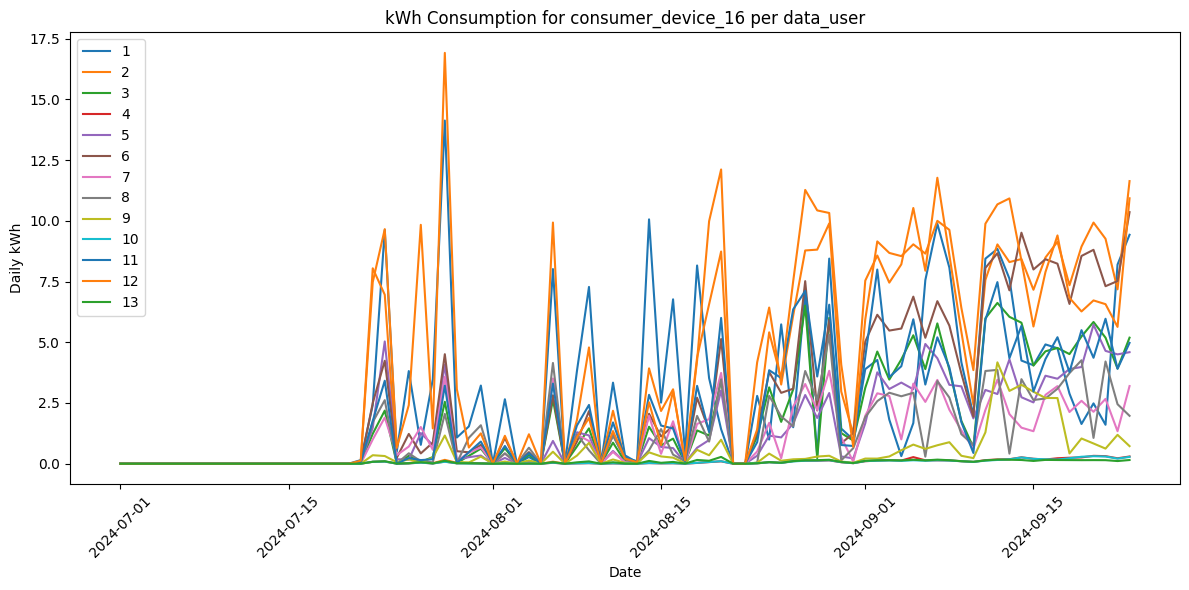

In [18]:

import matplotlib.pyplot as plt

# Example: daily_df is already your aggregated Polars DataFrame
# with columns similar to: data_user, consumer_device_x, date, daily_v_red, daily_v_blue,
# daily_v_yellow, daily_current, daily_power_factor, daily_kwh

# Set your desired device number
device_number = 16  # Change this to the device you want

# Filter data for the selected consumer device (consumer_device_x is an i32 column)
daily_device_df = filtered_devices_df.filter(pl.col("consumer_device_x") == device_number)

# Convert to pandas for plotting
daily_device_df_pd = daily_device_df.to_pandas()

# Create a plot for each data_user
plt.figure(figsize=(12, 6))
for data_user in daily_device_df_pd['data_user'].unique():
    # Filter data for the specific data_user and sort by date
    user_data = daily_device_df_pd[daily_device_df_pd['data_user'] == data_user].sort_values("date")
    plt.plot(user_data['date'], user_data['daily_kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('Daily kWh')
plt.title(f'kWh Consumption for consumer_device_{device_number} per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


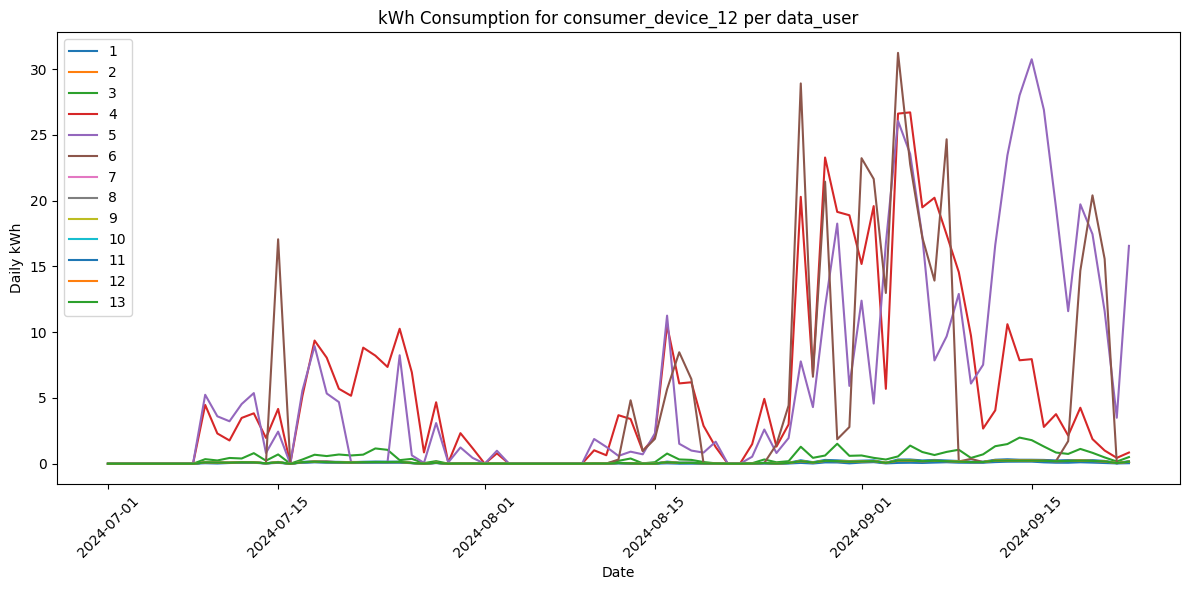

In [19]:

import matplotlib.pyplot as plt

# Example: daily_df is already your aggregated Polars DataFrame
# with columns similar to: data_user, consumer_device_x, date, daily_v_red, daily_v_blue,
# daily_v_yellow, daily_current, daily_power_factor, daily_kwh

# Set your desired device number
device_number = 12  # Change this to the device you want

# Filter data for the selected consumer device (consumer_device_x is an i32 column)
daily_device_df = filtered_devices_df.filter(pl.col("consumer_device_x") == device_number)

# Convert to pandas for plotting
daily_device_df_pd = daily_device_df.to_pandas()

# Create a plot for each data_user
plt.figure(figsize=(12, 6))
for data_user in daily_device_df_pd['data_user'].unique():
    # Filter data for the specific data_user and sort by date
    user_data = daily_device_df_pd[daily_device_df_pd['data_user'] == data_user].sort_values("date")
    plt.plot(user_data['date'], user_data['daily_kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('Daily kWh')
plt.title(f'kWh Consumption for consumer_device_{device_number} per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


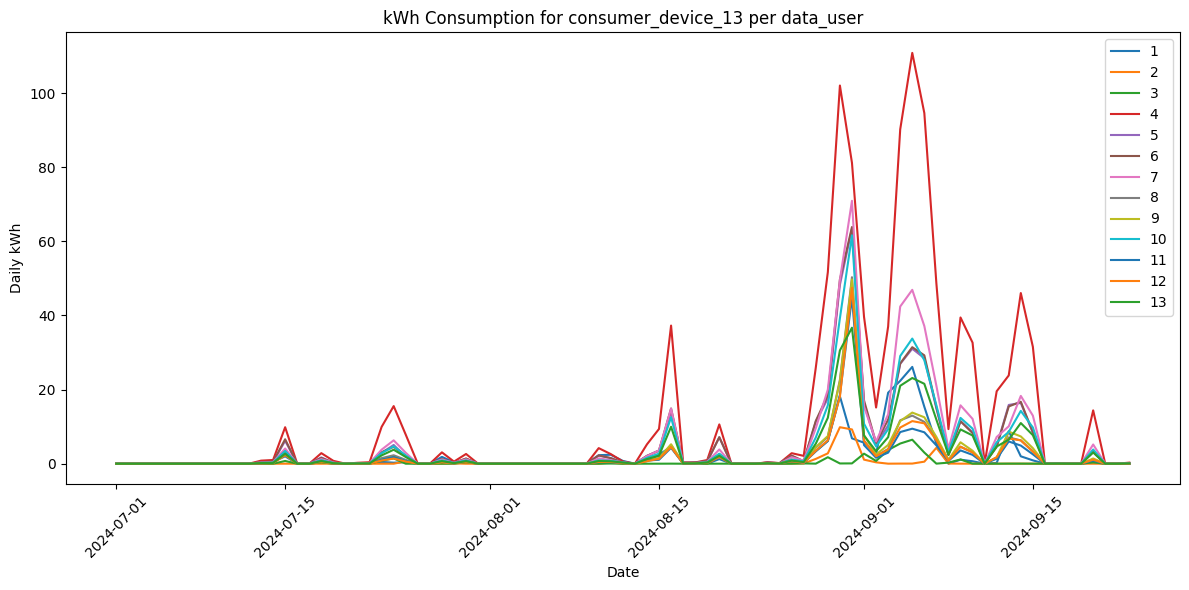

In [20]:

import matplotlib.pyplot as plt

# Example: daily_df is already your aggregated Polars DataFrame
# with columns similar to: data_user, consumer_device_x, date, daily_v_red, daily_v_blue,
# daily_v_yellow, daily_current, daily_power_factor, daily_kwh

# Set your desired device number
device_number = 13  # Change this to the device you want

# Filter data for the selected consumer device (consumer_device_x is an i32 column)
daily_device_df = filtered_devices_df.filter(pl.col("consumer_device_x") == device_number)

# Convert to pandas for plotting
daily_device_df_pd = daily_device_df.to_pandas()

# Create a plot for each data_user
plt.figure(figsize=(12, 6))
for data_user in daily_device_df_pd['data_user'].unique():
    # Filter data for the specific data_user and sort by date
    user_data = daily_device_df_pd[daily_device_df_pd['data_user'] == data_user].sort_values("date")
    plt.plot(user_data['date'], user_data['daily_kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('Daily kWh')
plt.title(f'kWh Consumption for consumer_device_{device_number} per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


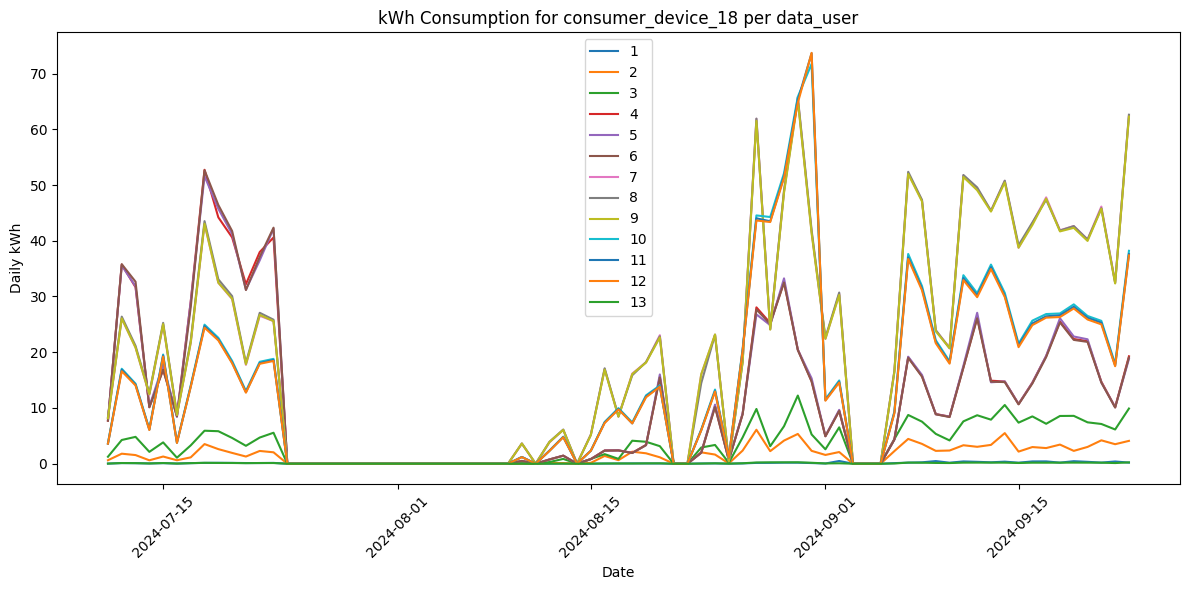

In [21]:

import matplotlib.pyplot as plt

# Example: daily_df is already your aggregated Polars DataFrame
# with columns similar to: data_user, consumer_device_x, date, daily_v_red, daily_v_blue,
# daily_v_yellow, daily_current, daily_power_factor, daily_kwh

# Set your desired device number
device_number = 18  # Change this to the device you want

# Filter data for the selected consumer device (consumer_device_x is an i32 column)
daily_device_df = filtered_devices_df.filter(pl.col("consumer_device_x") == device_number)

# Convert to pandas for plotting
daily_device_df_pd = daily_device_df.to_pandas()

# Create a plot for each data_user
plt.figure(figsize=(12, 6))
for data_user in daily_device_df_pd['data_user'].unique():
    # Filter data for the specific data_user and sort by date
    user_data = daily_device_df_pd[daily_device_df_pd['data_user'] == data_user].sort_values("date")
    plt.plot(user_data['date'], user_data['daily_kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('Daily kWh')
plt.title(f'kWh Consumption for consumer_device_{device_number} per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [22]:

# Assuming filtered_devices_df is your existing DataFrame with a column 'date'
min_date = filtered_devices_df.select(pl.col("date").min()).item()
max_date = filtered_devices_df.select(pl.col("date").max()).item()

print("Minimum date:", min_date)
print("Maximum date:", max_date)


Minimum date: 2024-07-01 00:00:00
Maximum date: 2024-09-23 00:00:00


In [23]:
# import polars as pl

# Update with your file path
climate_file_path = "/content/Kalam Climate Data.xlsx"

# Read the Excel file into a Polars DataFrame.
# Note: Ensure your Polars version supports Excel reading.
df = pl.read_excel(climate_file_path)

# Display the DataFrame
print(df)


shape: (12_228, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ Date Time  ┆ Temperatur ┆ Dewpoint   ┆ U Wind    ┆ V Wind    ┆ Total Pre ┆ Snowfall  ┆ Snow      │
│ ---        ┆ e (°C)     ┆ Temperatur ┆ Component ┆ Component ┆ cipitatio ┆ (mm)      ┆ Cover (%) │
│ datetime[m ┆ ---        ┆ e (°C)     ┆ (m/s)     ┆ (m/s)     ┆ n (mm)    ┆ ---       ┆ ---       │
│ s]         ┆ f64        ┆ ---        ┆ ---       ┆ ---       ┆ ---       ┆ f64       ┆ f64       │
│            ┆            ┆ f64        ┆ f64       ┆ f64       ┆ f64       ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2023-06-03 ┆ 7.199731   ┆ -2.448126  ┆ -0.034195 ┆ 0.060989  ┆ 0.000377  ┆ 0.0       ┆ 99.972656 │
│ 13:00:00   ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2023-06-03 ┆ 6.00062    ┆ -2.59754   ┆ -0.080688 ┆ 0.018585  ┆ 0.00039

In [24]:
# import numpy as np
# import polars as pl
from typing import List

def create_weather_features(
    climate_file_path: str,
    date_column: str = "Date Time",
    date_format: str = "%d/%m/%Y %H:%M:%S",
    lag_periods: List[int] = [1, 3, 7, 14, 30],    #lag_periods: List[int] = [1, 3, 7, 14, 30],
    rolling_windows: List[int] = [1, 7, 30, 90, 180, 365], #[3, 7, 14, 26, 42], #    rolling_windows: List[int] = [3, 7, 14, 30],
    ema_spans: List[int] = [3, 7, 14, 30],
    include_cyclical: bool = True
) -> pl.DataFrame:
    """
    Create advanced weather features using Polars from raw climate data.
    The function:
      - Loads and parses the Excel climate data.
      - Aggregates daily values.
      - Calculates derived features (wind speed, wind direction, heat index, etc.).
      - Uses dynamic breaks to categorize temperature and precipitation.
      - Creates lagged rainfall features and rolling/cumulative calculations.
      - Encodes all categorical (string) columns to numeric category codes.
    """
    # Read the Excel file using Polars
    climate_df = pl.read_excel(climate_file_path)

    # Convert date column to datetime (if not already), and truncate to daily granularity.
    if climate_df.schema[date_column] != pl.Datetime:
        climate_df = climate_df.with_columns(
            pl.col(date_column)
              .str.to_datetime(format=date_format)
              .dt.truncate("1d")
              .alias("Date")
        )
    else:
        climate_df = climate_df.with_columns(
            pl.col(date_column).dt.truncate("1d").alias("Date")
        )

    # Define aggregation expressions for daily feature creation.
    agg_expressions = [
        pl.col("Temperature (°C)").mean().alias("Temperature_mean"),
        pl.col("Temperature (°C)").max().alias("Temperature_max"),
        pl.col("Temperature (°C)").min().alias("Temperature_min"),
        pl.col("Temperature (°C)").std().alias("Temperature_std"),
        pl.col("Dewpoint Temperature (°C)").mean().alias("Dewpoint_Temperature_mean"),
        pl.col("U Wind Component (m/s)").mean().alias("U_Wind_Component_mean"),
        pl.col("U Wind Component (m/s)").max().alias("U_Wind_Component_max"),
        pl.col("V Wind Component (m/s)").mean().alias("V_Wind_Component_mean"),
        pl.col("V Wind Component (m/s)").max().alias("V_Wind_Component_max"),
        pl.col("Total Precipitation (mm)").sum().alias("Total_Precipitation_sum"),
        pl.col("Snowfall (mm)").sum().alias("Snowfall_sum"),
        pl.col("Snow Cover (%)").mean().alias("Snow_Cover_mean")
    ]

    # Group by Date to aggregate daily values.
    weather_df = climate_df.group_by("Date").agg(agg_expressions)

    # Calculate wind speed and wind direction.
    weather_df = weather_df.with_columns([
        (pl.col("U_Wind_Component_mean")**2 + pl.col("V_Wind_Component_mean")**2)
            .sqrt()
            .alias("Wind_Speed_mean"),
        pl.struct(["U_Wind_Component_mean", "V_Wind_Component_mean"]).map_elements(
            lambda s: np.degrees(np.arctan2(s["V_Wind_Component_mean"], s["U_Wind_Component_mean"])) % 360
        ).alias("Wind_Direction_degrees")
    ])

    # Create additional derived features.
    weather_df = weather_df.with_columns([
        (pl.col("Temperature_max") - pl.col("Temperature_min")).alias("Temperature_range"),
        (pl.col("Temperature_mean") - pl.col("Dewpoint_Temperature_mean")).alias("Temperature_dewpoint_difference")
    ])

    # Calculate a Heat Index if Temperature_mean > 20°C, else fallback to Temperature_mean.
    weather_df = weather_df.with_columns(
        pl.when(pl.col("Temperature_mean") > 20)
          .then(
             -42.379 +
             2.04901523 * pl.col("Temperature_mean") +
             10.14333127 * pl.col("Dewpoint_Temperature_mean") -
             0.22475541 * pl.col("Temperature_mean") * pl.col("Dewpoint_Temperature_mean") -
             0.00683783 * (pl.col("Temperature_mean")**2) -
             0.05481717 * (pl.col("Dewpoint_Temperature_mean")**2) +
             0.00122874 * (pl.col("Temperature_mean")**2) * pl.col("Dewpoint_Temperature_mean") +
             0.00085282 * pl.col("Temperature_mean") * (pl.col("Dewpoint_Temperature_mean")**2) -
             0.00000199 * (pl.col("Temperature_mean")**2) * (pl.col("Dewpoint_Temperature_mean")**2)
          )
          .otherwise(pl.col("Temperature_mean"))
          .alias("Heat_Index")
    )

    # Optionally, add cyclical features for wind direction.
    if include_cyclical:
       weather_df = weather_df.with_columns([
           pl.col("Wind_Direction_degrees")
             .map_elements(lambda x: np.sin(np.radians(x)))
             .alias("Wind_Direction_sin"),
           pl.col("Wind_Direction_degrees")
             .map_elements(lambda x: np.cos(np.radians(x)))
             .alias("Wind_Direction_cos")
       ])

    # Add date-based features: month, day, day-of-year, quarter, and weekday.
    weather_df = weather_df.with_columns([
        pl.col("Date").dt.month().alias("month"),
        pl.col("Date").dt.day().alias("day"),
        pl.col("Date").dt.ordinal_day().alias("day_of_year"),
        pl.col("Date").dt.quarter().alias("quarter"),
        pl.col("Date").dt.weekday().alias("day_of_week")
    ])

    # Optionally, add cyclical transformations for date features.
    if include_cyclical:
       weather_df = weather_df.with_columns([
           pl.col("month").map_elements(lambda x: np.sin(2 * np.pi * x / 12)).alias("month_sin"),
           pl.col("month").map_elements(lambda x: np.cos(2 * np.pi * x / 12)).alias("month_cos"),
           pl.col("day_of_year").map_elements(lambda x: np.sin(2 * np.pi * x / 366)).alias("day_of_year_sin"),
           pl.col("day_of_year").map_elements(lambda x: np.cos(2 * np.pi * x / 366)).alias("day_of_year_cos"),
           pl.col("day_of_week").map_elements(lambda x: np.sin(2 * np.pi * x / 7)).alias("day_of_week_sin"),
           pl.col("day_of_week").map_elements(lambda x: np.cos(2 * np.pi * x / 7)).alias("day_of_week_cos")
       ])

    # Assign a seasonal category based on month.
    weather_df = weather_df.with_columns(
        pl.when(pl.col("month").is_in([12, 1, 2])).then(pl.lit("Winter"))
          .when(pl.col("month").is_in([3, 4, 5])).then(pl.lit("Spring"))
          .when(pl.col("month").is_in([6, 7, 8])).then(pl.lit("Summer"))
          .otherwise(pl.lit("Fall"))
          .alias("season")
    )

    # # Create dynamic breaks for temperature categorization
    # temp_breaks = [15, 25, 30]  # 3 breaks → 4 bins
    # temp_labels = [0,1,2,3]  # 4 labels
    # #temp_labels = ["cold", "mild", "warm", "hot"]  # 4 labels

    # weather_df = weather_df.with_columns(
    #     pl.col("Temperature_mean").cut(breaks=temp_breaks, labels=temp_labels).alias("temp_category")
    # )

    # # Create dynamic breaks for precipitation categorization
    # precip_breaks = [15, 25, 30]
    # precip_labels = [0,1,2,4]
    # #precip_labels = ["none", "light", "moderate", "heavy"]
    # weather_df = weather_df.with_columns(
    #     pl.col("Total_Precipitation_sum").cut(breaks=precip_breaks, labels=precip_labels).alias("precip_category")
    # )

    # Sort by date to ensure proper lag ordering
    weather_df = weather_df.sort("Date")

    # ----- Add lagged rainfall features -----
    # These features show rainfall from previous days
    for lag in lag_periods:
        weather_df = weather_df.with_columns(
            pl.col("Total_Precipitation_sum").shift(lag).alias(f"Rainfall_lag_{lag}")
        )

    # ----- Add bidirectional (wrap-around) rainfall lags -----
    # These create both forward and backward looking rainfall features
    for lag in lag_periods:
        # Create right-to-left (backward) lag - standard lag showing previous days
        weather_df = weather_df.with_columns(
            pl.col("Total_Precipitation_sum").shift(lag).alias(f"Rainfall_lag_backward_{lag}")
        )

        # Create left-to-right (forward) lag - showing future days' rainfall
        weather_df = weather_df.with_columns(
            pl.col("Total_Precipitation_sum").shift(-lag).alias(f"Rainfall_lag_forward_{lag}")
        )

    # ----- Add rolling window calculations for rainfall -----
    # These show statistics over moving windows of days
    for window in rolling_windows:
        weather_df = weather_df.with_columns([
            pl.col("Total_Precipitation_sum")
                .rolling_mean(window_size=window)
                .alias(f"Rainfall_rolling_mean_{window}"),
            pl.col("Total_Precipitation_sum")
                .rolling_sum(window_size=window)
                .alias(f"Rainfall_rolling_sum_{window}"),
            pl.col("Total_Precipitation_sum")
                .rolling_max(window_size=window)
                .alias(f"Rainfall_rolling_max_{window}")
        ])

    # ----- Add exponential moving averages for rainfall -----
    for span in ema_spans:
        alpha = 2 / (span + 1)  # Calculate alpha parameter for EMA
        weather_df = weather_df.with_columns(
            pl.col("Total_Precipitation_sum")
                .ewm_mean(alpha=alpha)
                .alias(f"Rainfall_ema_{span}")
        )

    # Add year-to-date cumulative rainfall
    weather_df = weather_df.with_columns([
        pl.col("Date").dt.year().alias("year")  # Add year column for grouping
    ])

    # Calculate cumulative rainfall within each year
    # weather_df = weather_df.with_columns([
    #     pl.col("Total_Precipitation_sum")
    #         .cumsum()
    #         .over("year")
    #         .alias("Rainfall_cumulative_ytd")
    # ])
    weather_df = weather_df.with_columns([
    pl.col("Total_Precipitation_sum")
        .cum_sum()  # Use cum_sum() instead of cumsum()
        .over("year")
        .alias("Rainfall_cumulative_ytd")
    ])


    # Add event time indicators before returning the dataframe
    # These can identify specific weather events or seasonal patterns

    # ----- Add rainfall event indicators -----
    # Heavy rainfall events (e.g., days with rainfall above 90th percentile)
    rainfall_threshold = weather_df["Total_Precipitation_sum"].quantile(0.9)
    weather_df = weather_df.with_columns(
        pl.when(pl.col("Total_Precipitation_sum") >= rainfall_threshold)
            .then(1)
            .otherwise(0)
            .alias("Heavy_Rainfall_Event")
    )

    # Prolonged dry spell indicators (e.g., consecutive days with no rainfall)
    # First, create a binary indicator for dry days
    weather_df = weather_df.with_columns(
        pl.when(pl.col("Total_Precipitation_sum") < 0.1)  # Less than 0.1mm is considered dry
            .then(1)
            .otherwise(0)
            .alias("Dry_Day")
    )

    # Calculate consecutive dry days
    # weather_df = weather_df.sort("Date").with_columns([
    #     pl.col("Dry_Day")
    #         .cum_sum()
    #         .sub(pl.col("Dry_Day").cum_sum().shift_and_fill(1, 0).over("Dry_Day", "==", 0))
    #         .alias("Consecutive_Dry_Days")
    # ])
    # weather_df = weather_df.sort("Date").with_columns([
    # pl.col("Dry_Day")
    #     .cum_sum()
    #     .sub(pl.col("Dry_Day").cum_sum().shift(1).fill_null(0).over("Dry_Day", "==", 0))
    #     .alias("Consecutive_Dry_Days")
    # ])
    weather_df = weather_df.sort("Date").with_columns(
    pl.when(pl.col("Dry_Day") == 1)
    .then(
        pl.int_range(1, pl.len() + 1).over(
            (pl.col("Dry_Day") != pl.col("Dry_Day").shift(1)).cum_sum()
        )
    )
    .otherwise(0)
    .alias("Consecutive_Dry_Days")
    )

    # Create drought indicator (e.g., 7+ consecutive dry days)
    weather_df = weather_df.with_columns(
        pl.when(pl.col("Consecutive_Dry_Days") >= 7)
            .then(1)
            .otherwise(0)
            .alias("Drought_Event")
    )

    # ----- Add temperature event indicators -----
    # Heat wave indicator (e.g., 3+ consecutive days with max temp above 90th percentile)
    temp_threshold = weather_df["Temperature_max"].quantile(0.9)
    weather_df = weather_df.with_columns(
        pl.when(pl.col("Temperature_max") >= temp_threshold)
            .then(1)
            .otherwise(0)
            .alias("Hot_Day")
    )

    # Calculate consecutive hot days
    # weather_df = weather_df.sort("Date").with_columns([
    #     pl.col("Hot_Day")
    #         .cumsum()
    #         .sub(pl.col("Hot_Day").cumsum().shift_and_fill(1, 0).over("Hot_Day", "==", 0))
    #         .alias("Consecutive_Hot_Days")
    # ])
    weather_df = weather_df.sort("Date").with_columns(
    pl.when(pl.col("Hot_Day") == 1)
    .then(
        pl.int_range(1, pl.len() + 1).over(
            (pl.col("Hot_Day") != pl.col("Hot_Day").shift(1)).cum_sum()
        )
    )
    .otherwise(0)
    .alias("Consecutive_Hot_Days")
    )
    # weather_df = weather_df.sort("Date").with_columns([
    # pl.col("Hot_Day")
    #     .cum_sum()  # Use cum_sum() instead of cumsum()
    #     .sub(pl.col("Hot_Day").cum_sum().shift(1).fill_null(0).over("Hot_Day", "==", 0))
    #     .alias("Consecutive_Hot_Days")
    # ])



    # Create heat wave indicator
    weather_df = weather_df.with_columns(
        pl.when(pl.col("Consecutive_Hot_Days") >= 3)
            .then(1)
            .otherwise(0)
            .alias("Heat_Wave_Event")
    )

    # ----- Add seasonal event indicators -----
    # Growing season indicator (simplified approach based on temperature)
    weather_df = weather_df.with_columns(
        pl.when(pl.col("Temperature_mean") > 10)  # Common threshold for plant growth
            .then(1)
            .otherwise(0)
            .alias("Growing_Season")
    )

    # ----- Add extreme weather event indicators -----
    # Strong wind event
    wind_threshold = weather_df["Wind_Speed_mean"].quantile(0.9)
    weather_df = weather_df.with_columns(
        pl.when(pl.col("Wind_Speed_mean") >= wind_threshold)
            .then(1)
            .otherwise(0)
            .alias("Strong_Wind_Event")
    )

    # ----- Add specific seasonal markers -----
    # First and last frost days (approximation using temperature threshold)
    weather_df = weather_df.with_columns(
        pl.when(pl.col("Temperature_min") <= 0)
            .then(1)
            .otherwise(0)
            .alias("Frost_Day")
    )

    # Group by year to find first and last frost
    frost_days = weather_df.filter(pl.col("Frost_Day") == 1)
    first_frosts = frost_days.group_by("year").agg(pl.col("Date").min().alias("First_Frost_Date"))
    last_frosts = frost_days.group_by("year").agg(pl.col("Date").max().alias("Last_Frost_Date"))

    # Join first and last frost information back to main dataframe
    weather_df = weather_df.join(first_frosts, on="year", how="left")
    weather_df = weather_df.join(last_frosts, on="year", how="left")

    # Create indicators for first/last frost days
    weather_df = weather_df.with_columns([
        pl.when(pl.col("Date") == pl.col("First_Frost_Date"))
            .then(1)
            .otherwise(0)
            .alias("First_Frost_Event"),
        pl.when(pl.col("Date") == pl.col("Last_Frost_Date"))
            .then(1)
            .otherwise(0)
            .alias("Last_Frost_Event")
    ])

    # ----- Add rainfall transition indicators -----
    # Indicators for sudden changes in rainfall patterns
    weather_df = weather_df.with_columns(
        pl.col("Total_Precipitation_sum")
            .diff()
            .alias("Rainfall_Change")
    )

    rainfall_change_threshold = weather_df["Rainfall_Change"].abs().quantile(0.9)
    weather_df = weather_df.with_columns(
        pl.when(pl.col("Rainfall_Change") >= rainfall_change_threshold)
            .then(1)
            .otherwise(0)
            .alias("Sudden_Rainfall_Increase"),

        pl.when(pl.col("Rainfall_Change") <= -rainfall_change_threshold)
            .then(1)
            .otherwise(0)
            .alias("Sudden_Rainfall_Decrease")
    )

    # Drop rows with any nulls resulting from feature engineering steps
    #weather_df = weather_df.drop_nulls()

    return weather_df

    # Example usage:
if __name__ == "__main__":
    # Path to your Excel climate data file
    # climate_file_path = "/content/Kalam Climate Data.xlsx"  # update with your file path
    # Call the function and receive a Polars DataFrame
    weather_features_df = create_weather_features(climate_file_path=climate_file_path)
    # Show the resulting DataFrame
    print(weather_features_df)


shape: (511, 88)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Date      ┆ Temperatu ┆ Temperatu ┆ Temperatu ┆ … ┆ Last_Fros ┆ Rainfall_ ┆ Sudden_Ra ┆ Sudden_R │
│ ---       ┆ re_mean   ┆ re_max    ┆ re_min    ┆   ┆ t_Event   ┆ Change    ┆ infall_In ┆ ainfall_ │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ crease    ┆ Decrease │
│ ms]       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ i32       ┆ f64       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ i32       ┆ i32      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2023-06-0 ┆ 1.86028   ┆ 7.199731  ┆ -1.513861 ┆ … ┆ 0         ┆ null      ┆ 0         ┆ 0        │
│ 3         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 00:00:00  ┆           ┆           ┆           ┆   ┆           ┆         

In [25]:
weather_features_df

Date,Temperature_mean,Temperature_max,Temperature_min,Temperature_std,Dewpoint_Temperature_mean,U_Wind_Component_mean,U_Wind_Component_max,V_Wind_Component_mean,V_Wind_Component_max,Total_Precipitation_sum,Snowfall_sum,Snow_Cover_mean,Wind_Speed_mean,Wind_Direction_degrees,Temperature_range,Temperature_dewpoint_difference,Heat_Index,Wind_Direction_sin,Wind_Direction_cos,month,day,day_of_year,quarter,day_of_week,month_sin,month_cos,day_of_year_sin,day_of_year_cos,day_of_week_sin,day_of_week_cos,season,Rainfall_lag_1,Rainfall_lag_3,Rainfall_lag_7,Rainfall_lag_14,Rainfall_lag_30,…,Rainfall_rolling_sum_7,Rainfall_rolling_max_7,Rainfall_rolling_mean_30,Rainfall_rolling_sum_30,Rainfall_rolling_max_30,Rainfall_rolling_mean_90,Rainfall_rolling_sum_90,Rainfall_rolling_max_90,Rainfall_rolling_mean_180,Rainfall_rolling_sum_180,Rainfall_rolling_max_180,Rainfall_rolling_mean_365,Rainfall_rolling_sum_365,Rainfall_rolling_max_365,Rainfall_ema_3,Rainfall_ema_7,Rainfall_ema_14,Rainfall_ema_30,year,Rainfall_cumulative_ytd,Heavy_Rainfall_Event,Dry_Day,Consecutive_Dry_Days,Drought_Event,Hot_Day,Consecutive_Hot_Days,Heat_Wave_Event,Growing_Season,Strong_Wind_Event,Frost_Day,First_Frost_Date,Last_Frost_Date,First_Frost_Event,Last_Frost_Event,Rainfall_Change,Sudden_Rainfall_Increase,Sudden_Rainfall_Decrease
datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i16,i8,i8,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64,i32,i32,i64,i32,i32,i64,i32,i32,i32,i32,datetime[ms],datetime[ms],i32,i32,f64,i32,i32
2023-06-03 00:00:00,1.86028,7.199731,-1.513861,3.005839,-3.348664,0.025054,0.071854,-0.657726,0.060989,0.004557,0.0,99.972656,0.658203,272.181408,8.713593,5.208944,1.86028,-0.999275,0.038064,6,3,154,2,6,1.2246e-16,-1.0,0.477536,-0.878612,-0.781831,0.62349,"""Summer""",null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.004557,0.004557,0.004557,0.004557,2023,0.004557,0,1,1,0,0,0,0,0,0,1,2023-06-03 00:00:00,2023-12-31 00:00:00,1,0,null,0,0
2023-06-04 00:00:00,3.99274,9.10058,-3.258566,4.32022,-1.905203,-0.180909,0.030151,-0.505298,0.271164,0.024096,0.0,99.972656,0.536706,250.301439,12.359146,5.897942,3.99274,-0.941479,-0.337072,6,4,155,2,7,1.2246e-16,-1.0,0.462383,-0.88668,-2.4493e-16,1.0,"""Summer""",0.004557,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.017583,0.015722,0.015025,0.014652,2023,0.028653,0,1,1,0,0,0,0,0,0,1,2023-06-03 00:00:00,2023-12-31 00:00:00,0,0,0.019539,0,0
2023-06-05 00:00:00,4.794523,10.031442,-4.962714,4.652554,-3.781657,-0.145114,0.122162,-0.498183,0.256577,0.01158,0.000001,99.972656,0.518888,253.759851,14.994156,8.576181,4.794523,-0.960098,-0.279664,6,5,156,2,1,1.2246e-16,-1.0,0.447094,-0.894487,0.781831,0.62349,"""Summer""",0.024096,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.014153,0.013931,0.013709,0.013559,2023,0.040233,0,1,2,0,0,0,0,0,0,1,2023-06-03 00:00:00,2023-12-31 00:00:00,0,0,-0.012517,0,0
2023-06-06 00:00:00,6.30439,11.1495,0.213861,3.761622,-4.670615,0.018054,0.22435,-0.478623,0.313492,0.008914,5.2200e-8,99.972656,0.478963,272.160252,10.935638,10.975005,6.30439,-0.999289,0.037695,6,6,157,2,2,1.2246e-16,-1.0,0.431673,-0.90203,0.974928,-0.222521,"""Summer""",0.01158,0.004557,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.011359,0.012096,0.012242,0.012279,2023,0.049147,0,1,3,0,0,0,0,0,0,0,2023-06-03 00:00:00,2023-12-31 00:00:00,0,0,-0.002666,0,0
2023-06-07 00:00:00,7.003922,12.092218,1.434,3.768528,-3.965763,0.083701,0.540848,-0.516598,0.356873,0.00865,0.0,99.972656,0.523335,279.203337,10.658218,10.969686,7.003922,-0.987127,0.159939,6,7,158,2,3,1.2246e-16,-1.0,0.416125,-0.909308,0.433884,-0.900969,"""Summer""",0.008914,0.024096,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0

In [26]:
# Fill null values with zero
weather_features_df = weather_features_df.fill_null(0)


In [27]:
weather_features_df

Date,Temperature_mean,Temperature_max,Temperature_min,Temperature_std,Dewpoint_Temperature_mean,U_Wind_Component_mean,U_Wind_Component_max,V_Wind_Component_mean,V_Wind_Component_max,Total_Precipitation_sum,Snowfall_sum,Snow_Cover_mean,Wind_Speed_mean,Wind_Direction_degrees,Temperature_range,Temperature_dewpoint_difference,Heat_Index,Wind_Direction_sin,Wind_Direction_cos,month,day,day_of_year,quarter,day_of_week,month_sin,month_cos,day_of_year_sin,day_of_year_cos,day_of_week_sin,day_of_week_cos,season,Rainfall_lag_1,Rainfall_lag_3,Rainfall_lag_7,Rainfall_lag_14,Rainfall_lag_30,…,Rainfall_rolling_sum_7,Rainfall_rolling_max_7,Rainfall_rolling_mean_30,Rainfall_rolling_sum_30,Rainfall_rolling_max_30,Rainfall_rolling_mean_90,Rainfall_rolling_sum_90,Rainfall_rolling_max_90,Rainfall_rolling_mean_180,Rainfall_rolling_sum_180,Rainfall_rolling_max_180,Rainfall_rolling_mean_365,Rainfall_rolling_sum_365,Rainfall_rolling_max_365,Rainfall_ema_3,Rainfall_ema_7,Rainfall_ema_14,Rainfall_ema_30,year,Rainfall_cumulative_ytd,Heavy_Rainfall_Event,Dry_Day,Consecutive_Dry_Days,Drought_Event,Hot_Day,Consecutive_Hot_Days,Heat_Wave_Event,Growing_Season,Strong_Wind_Event,Frost_Day,First_Frost_Date,Last_Frost_Date,First_Frost_Event,Last_Frost_Event,Rainfall_Change,Sudden_Rainfall_Increase,Sudden_Rainfall_Decrease
datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i16,i8,i8,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64,i32,i32,i64,i32,i32,i64,i32,i32,i32,i32,datetime[ms],datetime[ms],i32,i32,f64,i32,i32
2023-06-03 00:00:00,1.86028,7.199731,-1.513861,3.005839,-3.348664,0.025054,0.071854,-0.657726,0.060989,0.004557,0.0,99.972656,0.658203,272.181408,8.713593,5.208944,1.86028,-0.999275,0.038064,6,3,154,2,6,1.2246e-16,-1.0,0.477536,-0.878612,-0.781831,0.62349,"""Summer""",0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004557,0.004557,0.004557,0.004557,2023,0.004557,0,1,1,0,0,0,0,0,0,1,2023-06-03 00:00:00,2023-12-31 00:00:00,1,0,0.0,0,0
2023-06-04 00:00:00,3.99274,9.10058,-3.258566,4.32022,-1.905203,-0.180909,0.030151,-0.505298,0.271164,0.024096,0.0,99.972656,0.536706,250.301439,12.359146,5.897942,3.99274,-0.941479,-0.337072,6,4,155,2,7,1.2246e-16,-1.0,0.462383,-0.88668,-2.4493e-16,1.0,"""Summer""",0.004557,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017583,0.015722,0.015025,0.014652,2023,0.028653,0,1,1,0,0,0,0,0,0,1,2023-06-03 00:00:00,2023-12-31 00:00:00,0,0,0.019539,0,0
2023-06-05 00:00:00,4.794523,10.031442,-4.962714,4.652554,-3.781657,-0.145114,0.122162,-0.498183,0.256577,0.01158,0.000001,99.972656,0.518888,253.759851,14.994156,8.576181,4.794523,-0.960098,-0.279664,6,5,156,2,1,1.2246e-16,-1.0,0.447094,-0.894487,0.781831,0.62349,"""Summer""",0.024096,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014153,0.013931,0.013709,0.013559,2023,0.040233,0,1,2,0,0,0,0,0,0,1,2023-06-03 00:00:00,2023-12-31 00:00:00,0,0,-0.012517,0,0
2023-06-06 00:00:00,6.30439,11.1495,0.213861,3.761622,-4.670615,0.018054,0.22435,-0.478623,0.313492,0.008914,5.2200e-8,99.972656,0.478963,272.160252,10.935638,10.975005,6.30439,-0.999289,0.037695,6,6,157,2,2,1.2246e-16,-1.0,0.431673,-0.90203,0.974928,-0.222521,"""Summer""",0.01158,0.004557,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011359,0.012096,0.012242,0.012279,2023,0.049147,0,1,3,0,0,0,0,0,0,0,2023-06-03 00:00:00,2023-12-31 00:00:00,0,0,-0.002666,0,0
2023-06-07 00:00:00,7.003922,12.092218,1.434,3.768528,-3.965763,0.083701,0.540848,-0.516598,0.356873,0.00865,0.0,99.972656,0.523335,279.203337,10.658218,10.969686,7.003922,-0.987127,0.159939,6,7,158,2,3,1.2246e-16,-1.0,0.416125,-0.909308,0.433884,-0.900969,"""Summer""",0.008914,0.024096,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00996,0.010966,0.011304,0.011453,2023,0.057796,0,1,4,0,0,0,0,0,0,0,2023-06-03 00:00:00,20

In [28]:

# Encode 'season' into small integers like 0, 1, 2, ...
# weather_features_df = weather_features_df.with_columns(
#     pl.col("season").cast(pl.Categorical).rank("dense").cast(pl.UInt32).alias("season_encoded")
# )

weather_features_df = weather_features_df.with_columns(
    (pl.col("season").cast(pl.Categorical).rank("dense") - 1).cast(pl.UInt32).alias("season_encoded")
).drop("season")


In [29]:
# print encoded values
print(weather_features_df.select(["season_encoded"]))

shape: (511, 1)
┌────────────────┐
│ season_encoded │
│ ---            │
│ u32            │
╞════════════════╡
│ 0              │
│ 0              │
│ 0              │
│ 0              │
│ 0              │
│ …              │
│ 1              │
│ 1              │
│ 1              │
│ 1              │
│ 1              │
└────────────────┘


In [30]:
min_date_s = weather_features_df.select(pl.col("Date").min()).item()
max_date_s = weather_features_df.select(pl.col("Date").max()).item()

print("Minimum date:", min_date_s)
print("Maximum date:", max_date_s)


Minimum date: 2023-06-03 00:00:00
Maximum date: 2024-10-25 00:00:00


In [31]:
weather_features_df = weather_features_df.with_columns(
    pl.col("Date").cast(pl.Date)  # Cast the 'Date' column to pl.Date
)

In [32]:
filtered_devices_df = filtered_devices_df.with_columns(
    pl.col("date").cast(pl.Date)  # Cast the 'date' column to pl.Date
)

In [33]:
weather_features_df['Date']

Date
date
2023-06-03
2023-06-04
2023-06-05
2023-06-06
2023-06-07
…
2024-10-21
2024-10-22
2024-10-23


In [34]:
test_df['date']

date
date
2024-09-24
2024-09-25
2024-09-26
2024-09-27
2024-09-28
…
2024-10-20
2024-10-21
2024-10-22


In [35]:
filtered_devices_df['date']

date
date
2024-07-01
2024-07-01
2024-07-01
2024-07-01
2024-07-01
…
2024-09-23
2024-09-23
2024-09-23


In [36]:
filtered_devices_df

ID,data_user,consumer_device_x,date,daily_v_red,daily_v_blue,daily_v_yellow,daily_current,daily_power_factor,daily_kwh
cat,i64,i32,date,f64,f64,f64,f64,f64,f64
"""2024-07-01_consumer_device_2_d…",1,2,2024-07-01,0.0,0.0,0.0,0.0,0.0,0.0
"""2024-07-01_consumer_device_8_d…",1,8,2024-07-01,0.0,0.0,0.0,0.0,0.0,0.0
"""2024-07-01_consumer_device_12_…",1,12,2024-07-01,0.0,0.0,0.0,0.0,0.0,0.0
"""2024-07-01_consumer_device_13_…",1,13,2024-07-01,0.0,0.0,0.0,0.0,0.0,0.0
"""2024-07-01_consumer_device_16_…",1,16,2024-07-01,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…
"""2024-09-23_consumer_device_32_…",13,32,2024-09-23,55083.91,0.0,0.0,0.08934,0.742083,0.310711
"""2024-09-23_consumer_device_35_…",13,35,2024-09-23,58353.67,0.0,0.0,0.063368,0.745799,0.229967
"""2024-09-23_consumer_device_36_…",13,36,2024-09-23,0.0,0.0,59509.62,0.082674,0.745313,0.307945


In [37]:
test_df

ID,kwh,date,consumer_device_x,data_user
str,i64,date,i32,i32
"""2024-09-24_consumer_device_12_…",0,2024-09-24,12,1
"""2024-09-25_consumer_device_12_…",0,2024-09-25,12,1
"""2024-09-26_consumer_device_12_…",0,2024-09-26,12,1
"""2024-09-27_consumer_device_12_…",0,2024-09-27,12,1
"""2024-09-28_consumer_device_12_…",0,2024-09-28,12,1
…,…,…,…,…
"""2024-10-20_consumer_device_8_d…",0,2024-10-20,8,9
"""2024-10-21_consumer_device_8_d…",0,2024-10-21,8,9
"""2024-10-22_consumer_device_8_d…",0,2024-10-22,8,9


In [38]:
train_data = filtered_devices_df.join(
    weather_features_df, left_on="date", right_on="Date", how="left"
)

In [39]:
train_data

ID,data_user,consumer_device_x,date,daily_v_red,daily_v_blue,daily_v_yellow,daily_current,daily_power_factor,daily_kwh,Temperature_mean,Temperature_max,Temperature_min,Temperature_std,Dewpoint_Temperature_mean,U_Wind_Component_mean,U_Wind_Component_max,V_Wind_Component_mean,V_Wind_Component_max,Total_Precipitation_sum,Snowfall_sum,Snow_Cover_mean,Wind_Speed_mean,Wind_Direction_degrees,Temperature_range,Temperature_dewpoint_difference,Heat_Index,Wind_Direction_sin,Wind_Direction_cos,month,day,day_of_year,quarter,day_of_week,month_sin,month_cos,day_of_year_sin,…,Rainfall_rolling_max_7,Rainfall_rolling_mean_30,Rainfall_rolling_sum_30,Rainfall_rolling_max_30,Rainfall_rolling_mean_90,Rainfall_rolling_sum_90,Rainfall_rolling_max_90,Rainfall_rolling_mean_180,Rainfall_rolling_sum_180,Rainfall_rolling_max_180,Rainfall_rolling_mean_365,Rainfall_rolling_sum_365,Rainfall_rolling_max_365,Rainfall_ema_3,Rainfall_ema_7,Rainfall_ema_14,Rainfall_ema_30,year,Rainfall_cumulative_ytd,Heavy_Rainfall_Event,Dry_Day,Consecutive_Dry_Days,Drought_Event,Hot_Day,Consecutive_Hot_Days,Heat_Wave_Event,Growing_Season,Strong_Wind_Event,Frost_Day,First_Frost_Date,Last_Frost_Date,First_Frost_Event,Last_Frost_Event,Rainfall_Change,Sudden_Rainfall_Increase,Sudden_Rainfall_Decrease,season_encoded
cat,i64,i32,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i16,i8,i8,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64,i32,i32,i64,i32,i32,i64,i32,i32,i32,i32,datetime[ms],datetime[ms],i32,i32,f64,i32,i32,u32
"""2024-07-01_consumer_device_2_d…",1,2,2024-07-01,0.0,0.0,0.0,0.0,0.0,0.0,14.942716,20.636362,6.654077,4.385016,8.577978,0.320656,0.722504,0.228913,1.174975,0.00627,0.0,0.021322,0.393982,35.522552,13.982285,6.364738,14.942716,0.581023,0.813887,7,1,183,3,1,-0.5,-0.866025,1.2246e-16,…,0.059048,0.062712,1.88137,0.23063,0.078143,7.032847,0.916742,0.070744,12.733887,0.919713,0.053031,19.356461,0.919713,0.018909,0.034766,0.047977,0.054563,2024,12.734121,0,1,10,1,1,2,0,1,0,0,2024-01-01 00:00:00,2024-10-25 00:00:00,0,0,-0.008546,0,0,0
"""2024-07-01_consumer_device_8_d…",1,8,2024-07-01,0.0,0.0,0.0,0.0,0.0,0.0,14.942716,20.636362,6.654077,4.385016,8.577978,0.320656,0.722504,0.228913,1.174975,0.00627,0.0,0.021322,0.393982,35.522552,13.982285,6.364738,14.942716,0.581023,0.813887,7,1,183,3,1,-0.5,-0.866025,1.2246e-16,…,0.059048,0.062712,1.88137,0.23063,0.078143,7.032847,0.916742,0.070744,12.733887,0.919713,0.053031,19.356461,0.919713,0.018909,0.034766,0.047977,0.054563,2024,12.734121,0,1,10,1,1,2,0,1,0,0,2024-01-01 00:00:00,2024-10-25 00:00:00,0,0,-0.008546,0,0,0
"""2024-07-01_consumer_device_12_…",1,12,2024-07-01,0.0,0.0,0.0,0.0,0.0,0.0,14.942716,20.636362,6.654077,4.385016,8.577978,0.320656,0.722504,0.228913,1.174975,0.00627,0.0,0.021322,0.393982,35.522552,13.982285,6.364738,14.942716,0.581023,0.813887,7,1,183,3,1,-0.5,-0.866025,1.2246e-16,…,0.059048,0.062712,1.88137,0.23063,0.078143,7.032847,0.916742,0.070744,12.733887,0.919713,0.053031,19.356461,0.919713,0.018909,0.034766,0.047977,0.054563,2024,12.734121,0,1,10,1,1,2,0,1,0,0,2024-01-01 00:00:00,2024-10-25 00:00:00,0,0,-0.008546,0,0,0
"""2024-07-01_consumer_device_13_…",1,13,2024-07-01,0.0,0.0,0.0,0.0,0.0,0.0,14.942716,20.636362,6.654077,4.385016,8.577978,0.320656,0.722504,0.228913,1.174975,0.00627,0.0,0.021322,0.393982,35.522552,13.982285,6.364738,14.942716,0.581023,0.813887,7,1,183,3,1,-0.5,-0.866025,1.2246e-16,…,0.059048,0.062712,1.88137,0.23063,0.078143,7.032847,0.916742,0.070744,12.733887,0.919713,0.053031,19.356461,0.919713,0.018909,0.034766,0.047977,0.054563,2024,12.734121,0,1,10,1,1,2,0,1,0,0,2024-01-01 00:00:00,2024-10-25 00:00:00,0,0,-0.008546,0,0,0
"""2024-07-01_consumer_device_16_…",1,16,2024-07-01,0.0,0.0,0.0,0.0,0.0,0.0,14.942716,20.636362,6.654077,4.385016,8.577978,0.320656,0.722504,0.228913,1.174975,0.00627,0.0,0.021322,0.393982,35.522552,13.982285,6.364738,14.942716,0.581023,0.813887,7,1,183,3,1,-0.5,-0.866

In [40]:
train_data = train_data.sort('data_user','consumer_device_x','date')
print("Sample training data:")
print(train_data)

Sample training data:
shape: (16_295, 97)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ ID        ┆ data_user ┆ consumer_ ┆ date      ┆ … ┆ Rainfall_ ┆ Sudden_Ra ┆ Sudden_Ra ┆ season_e │
│ ---       ┆ ---       ┆ device_x  ┆ ---       ┆   ┆ Change    ┆ infall_In ┆ infall_De ┆ ncoded   │
│ cat       ┆ i64       ┆ ---       ┆ date      ┆   ┆ ---       ┆ crease    ┆ crease    ┆ ---      │
│           ┆           ┆ i32       ┆           ┆   ┆ f64       ┆ ---       ┆ ---       ┆ u32      │
│           ┆           ┆           ┆           ┆   ┆           ┆ i32       ┆ i32       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2024-07-0 ┆ 1         ┆ 2         ┆ 2024-07-0 ┆ … ┆ -0.008546 ┆ 0         ┆ 0         ┆ 0        │
│ 1_consume ┆           ┆           ┆ 1         ┆   ┆           ┆           ┆           ┆          │
│ r_device_ ┆           ┆           ┆           ┆

In [41]:
train_data = train_data.rename({"daily_kwh": "kwh"})


In [42]:
# Assuming train_data is your DataFrame
date_datetime_columns = [col for col, dtype in train_data.schema.items()
                           if dtype in (pl.Date, pl.Datetime)]

# Now select those columns
df_dates = train_data.select(date_datetime_columns)

print(df_dates)

shape: (16_295, 3)
┌────────────┬─────────────────────┬─────────────────────┐
│ date       ┆ First_Frost_Date    ┆ Last_Frost_Date     │
│ ---        ┆ ---                 ┆ ---                 │
│ date       ┆ datetime[ms]        ┆ datetime[ms]        │
╞════════════╪═════════════════════╪═════════════════════╡
│ 2024-07-01 ┆ 2024-01-01 00:00:00 ┆ 2024-10-25 00:00:00 │
│ 2024-07-02 ┆ 2024-01-01 00:00:00 ┆ 2024-10-25 00:00:00 │
│ 2024-07-03 ┆ 2024-01-01 00:00:00 ┆ 2024-10-25 00:00:00 │
│ 2024-07-04 ┆ 2024-01-01 00:00:00 ┆ 2024-10-25 00:00:00 │
│ 2024-07-05 ┆ 2024-01-01 00:00:00 ┆ 2024-10-25 00:00:00 │
│ …          ┆ …                   ┆ …                   │
│ 2024-09-19 ┆ 2024-01-01 00:00:00 ┆ 2024-10-25 00:00:00 │
│ 2024-09-20 ┆ 2024-01-01 00:00:00 ┆ 2024-10-25 00:00:00 │
│ 2024-09-21 ┆ 2024-01-01 00:00:00 ┆ 2024-10-25 00:00:00 │
│ 2024-09-22 ┆ 2024-01-01 00:00:00 ┆ 2024-10-25 00:00:00 │
│ 2024-09-23 ┆ 2024-01-01 00:00:00 ┆ 2024-10-25 00:00:00 │
└────────────┴─────────────────────┴─

In [ ]:
# We define the meta features (to be used in the stacking meta learner)
# meta_features_cols = [
#     "daily_v_red", "daily_v_blue", "daily_v_yellow", "daily_current", "daily_power_factor"
# ]

In [43]:
target = "kwh"

In [44]:
# Exclude columns that are not features (IDs, dates, target, etc.).
drop_columns = ["ID", "date", "Date",'First_Frost_Date','Last_Frost_Date', "kwh","daily_v_red", "daily_v_blue", "daily_v_yellow", "daily_current", "daily_power_factor"]

In [45]:
# you can refine feature selection as needed.
base_feature_cols = [col for col in train_data.columns if col not in drop_columns]

# Convert the training data to a pandas DataFrame for scikit-learn compatibility.
train_df = train_data.select(base_feature_cols + [target]).to_pandas()
X_base = train_df[base_feature_cols]
y = train_df[target].values

In [ ]:
#y = np.log1p(train_df[target].values)

In [ ]:
# For the meta stage, we will use the five specified meta feature columns from the training data.
#meta_train_features = train_df[meta_features_cols].values

In [46]:
X_base

,data_user,consumer_device_x,Temperature_mean,Temperature_max,Temperature_min,Temperature_std,Dewpoint_Temperature_mean,U_Wind_Component_mean,U_Wind_Component_max,V_Wind_Component_mean,...,Heat_Wave_Event,Growing_Season,Strong_Wind_Event,Frost_Day,First_Frost_Event,Last_Frost_Event,Rainfall_Change,Sudden_Rainfall_Increase,Sudden_Rainfall_Decrease,season_encoded
0,1,2,14.942716,20.636362,6.654077,4.385016,8.577978,0.320656,0.722504,0.228913,...,0,1,0,0,0,0,-0.008546,0,0,0
1,1,2,15.080516,19.956979,8.812982,3.963418,7.864159,0.324458,0.821136,0.259530,...,1,1,0,0,0,0,-0.003865,0,0,0
2,1,2,15.770147,20.699167,8.371027,3.786125,9.578964,0.275826,0.651321,0.350732,...,1,1,0,0,0,0,0.001930,0,0,0
3,1,2,15.277408,20.313837,11.273233,2.825163,11.471116,0.441994,1.187332,0.350547,...,1,1,0,0,0,0,0.040441,0,0,0
4,1,2,13.950413,18.751962,7.636301,3.604960,8.368979,0.368354,0.946182,0.321995,...,0,1,0,0,0,0,-0.020035,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16290,19,32,10.415409,15.753839,3.567911,4.264982,1.626889,-0.011655,0.533752,-0.156432,...,0,1,0,0,0,0,-0.008589,0,0,1
16291,19,32,12.154204,18.019144,4.974176,4.566110,1.086294,-0.133177,0.119888,-0.239482,...,0,1,0,0,0,0,-0.003571,0,0,1
16292,19,32,13.219773,19.153406,6.373270,4.614267,1.432244,-0.098764,0.100616,-0.306270,...,0,1,0,0,0,0,-0.001469,0,0,1
16293,19,32,14.080013,20.946268,6.942697,5.105972,1.195233,-0.069137,0.132645,-0.309662,...,0,1,0,0,0,0,-0.000778,0,0,1


In [ ]:
import optuna

In [ ]:
import optuna
from optuna.samplers import TPESampler

# Define the objective function (unchanged)
def objective(trial):
    cat_learning_rate = trial.suggest_float('cat_learning_rate', 0.001, 0.1, log=True)
    cat_depth = trial.suggest_int('cat_depth', 6, 12)
    cat_l2_leaf_reg = trial.suggest_float('cat_l2_leaf_reg', 1e-3, 20, log=True)
    cat_bagging_temperature = trial.suggest_float('cat_bagging_temperature', 0.0, 3.0)
    cat_random_strength = trial.suggest_float('cat_random_strength', 1e-9, 1.0, log=True)
    cat_grow_policy = trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise'])
    cat_boosting_type = trial.suggest_categorical('boosting_type', ['Plain'])
    cat_border_count = trial.suggest_int("cat_border_count", 32, 255)

    tscv = TimeSeriesSplit(n_splits=5)
    oof_pred = np.zeros(len(X_base))
    fold_rmse = []

    for train_idx, valid_idx in tscv.split(X_base):
        X_train, X_valid = X_base.iloc[train_idx], X_base.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = CatBoostRegressor(
            iterations=1000,
            learning_rate=cat_learning_rate,
            depth=cat_depth,
            l2_leaf_reg=cat_l2_leaf_reg,
            bagging_temperature=cat_bagging_temperature,
            random_strength=cat_random_strength,
            border_count=cat_border_count,
            grow_policy=cat_grow_policy,
            boosting_type=cat_boosting_type,
            loss_function='RMSE',
            task_type='GPU',
            devices='0:1',  # Use multiple GPUs if available
            verbose=0,
            random_seed=42,
            early_stopping_rounds=50,  # Add early stopping
            use_best_model=True  # Use best model from early stopping
        )
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
        pred = model.predict(X_valid)
        oof_pred[valid_idx] = pred
        fold_rmse.append(np.sqrt(mean_squared_error(y_valid, pred)))

        # pred = np.expm1(model.predict(X_valid))
        # # Similarly, convert validation targets back to original scale
        # true = np.expm1(y_valid)
        # oof_pred[valid_idx] = pred
        # fold_rmse.append(np.sqrt(mean_squared_error(true, pred)))

    return np.mean(fold_rmse)

# Create a multivariate TPE sampler
sampler = TPESampler(multivariate=True)

# Create a named study using the multivariate sampler
study = optuna.create_study(
    study_name="catboost_multivariate_study",
    direction="minimize",
    sampler=sampler
)

# Run the optimization
study.optimize(objective, n_trials=100)

# Output the best parameters
print("Best CatBoost Params:")
for k, v in study.best_trial.params.items():
    print(f"{k}: {v}")


Trial 0 finished with value: 6.5830464925270835 and parameters: {'cat_learning_rate': 0.005069371970535685, 'cat_depth': 12, 'cat_l2_leaf_reg': 0.8025019784189545, 'cat_bagging_temperature': 2.5463853988629523, 'cat_random_strength': 0.29726327603745295, 'grow_policy': 'Depthwise', 'boosting_type': 'Plain', 'cat_border_count': 130}. Best is trial 0 with value: 6.5830464925270835.

In [ ]:
# # --- lightgbm_optuna.py ---
# # import lightgbm as lgb


# def objective(trial):
#     params = {
#         "objective": "regression",
#         "metric": "rmse",
#         "learning_rate": trial.suggest_float("lgb_learning_rate", 0.005, 0.2, log=True),
#         "num_leaves": trial.suggest_int("lgb_num_leaves", 20, 150),
#         "max_depth": trial.suggest_int("lgb_max_depth", 3, 15),
#         "min_child_samples": trial.suggest_int("lgb_min_child_samples", 5, 100),
#         "subsample": trial.suggest_float("lgb_subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("lgb_colsample_bytree", 0.5, 1.0),
#         "lambda_l1": trial.suggest_float("lgb_lambda_l1", 0.0, 5.0),
#         "lambda_l2": trial.suggest_float("lgb_lambda_l2", 0.0, 5.0),
#         "seed": 42,
#         "verbose": -1
#     }

#     tscv = TimeSeriesSplit(n_splits=10)
#     oof_pred = np.zeros(len(X_base))
#     fold_rmse = []

#     for train_idx, valid_idx in tscv.split(X_base):
#         X_train, X_valid = X_base.iloc[train_idx], X_base.iloc[valid_idx]
#         y_train, y_valid = y[train_idx], y[valid_idx]

#         lgb_train = lgb.Dataset(X_train, y_train)
#         lgb_valid = lgb.Dataset(X_valid, y_valid)

#         model = lgb.train(
#             params,
#             lgb_train,
#             num_boost_round=1000,
#             valid_sets=[lgb_train, lgb_valid],
#             callbacks=[lgb.early_stopping(100)]
#         )
#         pred = model.predict(X_valid, num_iteration=model.best_iteration)
#         oof_pred[valid_idx] = pred
#         fold_rmse.append(np.sqrt(mean_squared_error(y_valid, pred)))

#     return np.mean(fold_rmse)

# study = optuna.create_study(study_name="LightGBM_multivariate_study", direction="minimize",sampler=sampler)
# study.optimize(objective, n_trials=100)

# # Output the best parameters
# print("Best LightGBM Params:")
# for k, v in study.best_trial.params.items():
#     print(f"{k}: {v}")

In [ ]:
# --- xgboost_optuna.py ---
# import xgboost as xgb

# np.random.seed(42)

# def objective(trial):
#     params = {
#         "objective": "reg:squarederror",
#         "learning_rate": trial.suggest_float("xgb_learning_rate", 0.005, 0.2, log=True),
#         "max_depth": trial.suggest_int("xgb_max_depth", 3, 15),
#         "min_child_weight": trial.suggest_float("xgb_min_child_weight", 1.0, 10.0),
#         "gamma": trial.suggest_float("xgb_gamma", 0.0, 5.0),
#         "subsample": trial.suggest_float("xgb_subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("xgb_colsample_bytree", 0.5, 1.0),
#         "reg_lambda": trial.suggest_float("xgb_lambda", 0.0, 5.0),
#         "reg_alpha": trial.suggest_float("xgb_alpha", 0.0, 5.0),
#         "n_estimators": 1000,
#         "seed": 42,
#         "verbosity": 0,
#         "early_stopping_rounds": 100
#     }

#     tscv = TimeSeriesSplit(n_splits=5)
#     oof_pred = np.zeros(len(X_base))
#     fold_rmse = []

#     for train_idx, valid_idx in tscv.split(X_base):
#         X_train, X_valid = X_base.iloc[train_idx], X_base.iloc[valid_idx]
#         y_train, y_valid = y[train_idx], y[valid_idx]

#         model = xgb.XGBRegressor(**params)
#         model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
#         pred = model.predict(X_valid)
#         oof_pred[valid_idx] = pred
#         fold_rmse.append(np.sqrt(mean_squared_error(y_valid, pred)))

#     return np.mean(fold_rmse)

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)

# print("Best XGBoost Params:")
# for k, v in study.best_trial.params.items():
#     print(f"{k}: {v}")

In [47]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------
# SETUP TIME SERIES CROSS VALIDATION
# -----------------------------
tscv = TimeSeriesSplit(n_splits=10)
oof_meta = []   # To store meta features (base model predictions + meta columns) for training the meta learner.
oof_y = []      # The true target values for the meta stage.

# Store base models (if you wish to re-use later).
cat_models, lgb_models, xgb_models = [], [], []

# For out-of-fold predictions from each base model
oof_pred_cat = np.zeros(len(train_df))
oof_pred_lgb = np.zeros(len(train_df))
oof_pred_xgb = np.zeros(len(train_df))

In [48]:
lightgbm_params = {
    'learning_rate': 0.057571062091932,
    'num_leaves': 102,
    'max_depth': 12,
    'min_child_samples': 34,
    'subsample': 0.9399362218355389,
    'colsample_bytree': 0.7677425292377363,
    'lambda_l1': 3.438785627101125,
    'lambda_l2': 3.9927954996316855
}
cat_params = {
    'learning_rate': 0.005069371970535685,
    'depth': 12,
    'l2_leaf_reg': 0.8025019784189545,
    'bagging_temperature': 2.5463853988629523,
    'random_strength': 0.29726327603745295,
    'grow_policy': 'Depthwise',
    'boosting_type': 'Plain',
    'border_count': 130
}

xgb_params = {
    'learning_rate': 0.013620851125395145,
    'max_depth': 14,
    'min_child_weight': 1.9384245183138835,
    'gamma': 1.1838212597958628,
    'subsample': 0.8531178354327836,
    'colsample_bytree': 0.8024961916014401,
    'reg_lambda': 0.5096178621665522,
    'reg_alpha': 3.0768793205980556,
    'n_estimators': 1000
}

In [49]:
fold_num = 1
for train_idx, valid_idx in tscv.split(X_base):
    print(f"Fold {fold_num}")
    X_train, X_valid = X_base.iloc[train_idx], X_base.iloc[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    # ----- Base Model 1: CatBoost -----
    cat_model = CatBoostRegressor(
        iterations=1000, # Add the iterations parameter here
        loss_function='RMSE',
        verbose=0,
        random_seed=42,
        **cat_params  # Unpack cat_params for other parameters
    )
    cat_model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
    pred_cat = cat_model.predict(X_valid)
    cat_models.append(cat_model)

    # ----- Base Model 2: LightGBM -----
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

    lgb_model = lgb.train(
        params=lightgbm_params,
        train_set=lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_valid],
        #early_stopping_rounds=50,
        #verbose_eval=False
    )
    pred_lgb = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
    lgb_models.append(lgb_model)

    # ----- Base Model 3: XGBoost -----
    xgb_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        seed=42,
        verbosity=0,
        early_stopping_rounds=100,
        **xgb_params,
    )
    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],)
    pred_xgb = xgb_model.predict(X_valid)
    xgb_models.append(xgb_model)

    # Save out-of-fold base predictions.
    oof_pred_cat[valid_idx] = pred_cat
    oof_pred_lgb[valid_idx] = pred_lgb
    oof_pred_xgb[valid_idx] = pred_xgb

    # For the meta features, we combine the base predictions and the five specified meta columns.
    # (For valid indices, extract the meta features from the original training data.)
    fold_meta_features = np.column_stack((
        pred_cat,
        pred_lgb,
        pred_xgb,
    ))

    oof_meta.append(fold_meta_features)
    oof_y.append(y_valid)

    rmse_fold = np.sqrt(mean_squared_error(y_valid, (pred_cat + pred_lgb + pred_xgb) / 3))
    print(f"Fold {fold_num} RMSE (base ensemble average): {rmse_fold:.4f}")
    fold_num += 1

# Concatenate meta training data and targets across folds.
meta_X = np.vstack(oof_meta)
meta_y = np.concatenate(oof_y)
print("Meta stage training data shape:", meta_X.shape)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
import optuna
from optuna.samplers import TPESampler
# from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# import numpy as np

# Define the Optuna objective
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": 0
    }

    model = XGBRegressor(**params)
    model.fit(meta_X, meta_y)

    preds = model.predict(meta_X)
    rmse = np.sqrt(mean_squared_error(meta_y, preds))
    return rmse

# Multivariate TPE sampler
sampler = TPESampler(multivariate=True, seed=42)

# Create study with custom name
study = optuna.create_study(direction="minimize", sampler=sampler, study_name="XGB_MetaLearner_Optimization")
study.optimize(objective, n_trials=100)

# Output results
print("Best RMSE:", study.best_value)
print("Best Parameters:", study.best_params)

# # Train final model using best params
# best_model = XGBRegressor(random_state=42, **study.best_params)
# best_model.fit(meta_X, meta_y)
# meta_train_pred = best_model.predict(meta_X)
# meta_rmse = np.sqrt(mean_squared_error(meta_y, meta_train_pred))
# print(f"Tuned Meta Learner RMSE: {meta_rmse:.4f}")


In [ ]:
#Best RMSE: 3.8997880473507367
#Best Parameters: {'n_estimators': 710, 'max_depth': 10, 'learning_rate': 0.16105351262134737, 'subsample': 0.9908513635671748, 'colsample_bytree': 0.9016422055709359, 'gamma': 0.053815314374153614, 'reg_alpha': 0.7987826890571411, 'reg_lambda': 0.34653357236585225}

In [50]:
meta_params = {'n_estimators': 710, 'max_depth': 10, 'learning_rate': 0.16105351262134737, 'subsample': 0.9908513635671748, 'colsample_bytree': 0.9016422055709359, 'gamma': 0.053815314374153614, 'reg_alpha': 0.7987826890571411, 'reg_lambda': 0.34653357236585225}

In [51]:
# Train final model using best params
best_model = XGBRegressor(random_state=42, **meta_params)
best_model.fit(meta_X, meta_y)
meta_train_pred = best_model.predict(meta_X)
meta_rmse = np.sqrt(mean_squared_error(meta_y, meta_train_pred))
print(f"Tuned Meta Learner RMSE: {meta_rmse:.4f}")

Tuned Meta Learner RMSE: 3.8998


In [ ]:
# -----------------------------
# TRAIN META LEARNER
# -----------------------------

# Regressor XGBoost
meta_model = XGBRegressor(random_state=42,**xgb_params)

# Fit the model
meta_model.fit(meta_X, meta_y)

# Predict on training data
meta_train_pred = meta_model.predict(meta_X)

# Calculate RMSE
meta_rmse = np.sqrt(mean_squared_error(meta_y, meta_train_pred))
print(f"Meta learner training RMSE: {meta_rmse:.4f}")

# meta_model = LinearRegression()  # You can try any regressor (e.g., Ridge, XGBoost, etc.)
# meta_model.fit(meta_X, meta_y)
# meta_train_pred = meta_model.predict(meta_X)
# meta_rmse = np.sqrt(mean_squared_error(meta_y, meta_train_pred))
# print(f"Meta learner training RMSE: {meta_rmse:.4f}")

In [ ]:
# Save the model in JSON format
meta_model.save_model("meta_model.json")


In [ ]:
best_model.save_model("best_model.json")

In [52]:
# -----------------------------
# RETRAIN BASE MODELS ON FULL TRAINING DATA
# -----------------------------
# Retrain the final versions of the base models on the full training set.
# -----------------------------
# RETRAIN BASE MODELS ON FULL TRAINING DATA
# -----------------------------
# Retrain the final versions of the base models on the full training set.

final_cat = CatBoostRegressor(
        iterations=1000, # Add the iterations parameter here
        loss_function='RMSE',
        verbose=0,
        random_seed=42,
        **cat_params  # Unpack cat_params for other parameters
    )
final_cat.fit(X_base, y)

lgb_train_full = lgb.Dataset(X_base, label=y)
# Remove early stopping for final training
lightgbm_params.pop('early_stopping_rounds', None)
final_lgb = lgb.train(
    params=lightgbm_params,
    train_set=lgb_train_full,
    num_boost_round=1000,
    #verbose_eval=False
)

final_xgb = xgb.XGBRegressor(
    objective="reg:squarederror",
    seed=42,
    verbosity=0,
    **xgb_params,
)
final_xgb.fit(X_base, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4866
[LightGBM] [Info] Number of data points in the train set: 16295, number of used features: 81
[LightGBM] [Info] Start training from score 2.754249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8024961916014401, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1.1838212597958628,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.013620851125395145,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=1.9384245183138835, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [53]:
# -----------------------------
# GENERATE PREDICTIONS FOR THE TEST SET USING STACKED ENSEMBLE
# -----------------------------
# Merge test_df with weather features (as before) so that we have the same base features.
test_merged = test_df.join(
    weather_features_df,
    left_on="date",
    right_on="Date",
    how="left"
)
# test_merged = test_merged.select(base_feature_cols)  # ensure test contains base features
# test_df_pd = test_merged.to_pandas()

In [54]:
test_merged

ID,kwh,date,consumer_device_x,data_user,Temperature_mean,Temperature_max,Temperature_min,Temperature_std,Dewpoint_Temperature_mean,U_Wind_Component_mean,U_Wind_Component_max,V_Wind_Component_mean,V_Wind_Component_max,Total_Precipitation_sum,Snowfall_sum,Snow_Cover_mean,Wind_Speed_mean,Wind_Direction_degrees,Temperature_range,Temperature_dewpoint_difference,Heat_Index,Wind_Direction_sin,Wind_Direction_cos,month,day,day_of_year,quarter,day_of_week,month_sin,month_cos,day_of_year_sin,day_of_year_cos,day_of_week_sin,day_of_week_cos,Rainfall_lag_1,Rainfall_lag_3,…,Rainfall_rolling_max_7,Rainfall_rolling_mean_30,Rainfall_rolling_sum_30,Rainfall_rolling_max_30,Rainfall_rolling_mean_90,Rainfall_rolling_sum_90,Rainfall_rolling_max_90,Rainfall_rolling_mean_180,Rainfall_rolling_sum_180,Rainfall_rolling_max_180,Rainfall_rolling_mean_365,Rainfall_rolling_sum_365,Rainfall_rolling_max_365,Rainfall_ema_3,Rainfall_ema_7,Rainfall_ema_14,Rainfall_ema_30,year,Rainfall_cumulative_ytd,Heavy_Rainfall_Event,Dry_Day,Consecutive_Dry_Days,Drought_Event,Hot_Day,Consecutive_Hot_Days,Heat_Wave_Event,Growing_Season,Strong_Wind_Event,Frost_Day,First_Frost_Date,Last_Frost_Date,First_Frost_Event,Last_Frost_Event,Rainfall_Change,Sudden_Rainfall_Increase,Sudden_Rainfall_Decrease,season_encoded
str,i64,date,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i16,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64,i32,i32,i64,i32,i32,i64,i32,i32,i32,i32,datetime[ms],datetime[ms],i32,i32,f64,i32,i32,u32
"""2024-09-24_consumer_device_12_…",0,2024-09-24,12,1,13.899341,21.140833,6.350473,5.564236,2.104299,0.005811,0.201462,-0.264604,0.914259,0.000032,0.0,0.0,0.264667,271.258091,14.790359,11.795041,13.899341,-0.999759,0.021956,9,24,268,3,2,-1.0,-1.8370e-16,-0.993781,-0.111355,0.974928,-0.222521,0.000249,0.000825,…,0.014454,0.038841,1.165241,0.173941,0.051601,4.644101,0.189739,0.067739,12.193043,0.916742,0.052485,19.157169,0.919713,0.000816,0.007209,0.017109,0.030675,2024,17.240809,0,1,10,1,1,4,1,1,0,0,2024-01-01 00:00:00,2024-10-25 00:00:00,0,0,-0.000217,0,0,1
"""2024-09-25_consumer_device_12_…",0,2024-09-25,12,1,12.475849,17.764078,7.036218,3.6416,5.623678,0.22428,0.560196,0.183461,1.212889,0.003789,0.0,0.0,0.289758,39.283208,10.727859,6.852172,12.475849,0.633154,0.774026,9,25,269,3,3,-1.0,-1.8370e-16,-0.995546,-0.094279,0.433884,-0.900969,0.000032,0.000047,…,0.005865,0.03784,1.135192,0.173941,0.051359,4.622286,0.189739,0.066797,12.023468,0.916742,0.052447,19.14315,0.919713,0.002303,0.006354,0.015333,0.028941,2024,17.244599,0,1,11,1,0,0,0,1,0,0,2024-01-01 00:00:00,2024-10-25 00:00:00,0,0,0.003758,0,0,1
"""2024-09-26_consumer_device_12_…",0,2024-09-26,12,1,9.702699,13.710367,6.33436,2.3553,7.37516,0.202651,0.882935,0.044908,0.804711,0.12268,0.0,0.0,0.207568,12.494958,7.376007,2.327538,9.702699,0.216354,0.976315,9,26,270,3,4,-1.0,-1.8370e-16,-0.997018,-0.077175,-0.433884,-0.900969,0.003789,0.000249,…,0.12268,0.040199,1.205964,0.173941,0.05237,4.713291,0.189739,0.065076,11.713696,0.916742,0.052751,19.254072,0.919713,0.062491,0.035435,0.029646,0.034988,2024,17.367278,0,0,0,0,0,0,0,0,0,0,2024-01-01 00:00:00,2024-10-25 00:00:00,0,0,0.118891,1,0,1
"""2024-09-27_consumer_device_12_…",0,2024-09-27,12,1,6.806661,9.612451,4.086908,1.530768,5.905107,0.042285,0.555603,0.168467,1.211594,0.443926,0.019848,3.789225,0.173692,75.910004,5.525543,0.901553,6.806661,0.969915,0.243446,9,27,271,3,5,-1.0,-1.8370e-16,-0.998195,-0.060049,-0.974928,-0.222521,0.12268,0.000032,…,0.443926,0.054619,1.638561,0.443926,0.056646,5.098168,0.443926,0.067337,12.1207,0.916742,0.053745,19.616996,0.919713,0.253208,0.137558,0.084883,0.061371,2024,17.811204,1,0,0,0,0,0,0,0,0,0,2024-01-01 00:00:00,2024-10-25 00:00:00,0,0,0.321246,1,0,1
"""2024-09-28_consumer_device_12_…",0,2024-09-28,12,1,6.399286,10.17753,2.196313,2.587759,2.932036,-0.042425,0.288498,0.149797,1.358058,0.059494,0.001262,4.174235,0.155689,105.813

In [ ]:
# test_merged = test_merged.sort('data_user','consumer_device_x','date')

In [55]:
test_merged

ID,kwh,date,consumer_device_x,data_user,Temperature_mean,Temperature_max,Temperature_min,Temperature_std,Dewpoint_Temperature_mean,U_Wind_Component_mean,U_Wind_Component_max,V_Wind_Component_mean,V_Wind_Component_max,Total_Precipitation_sum,Snowfall_sum,Snow_Cover_mean,Wind_Speed_mean,Wind_Direction_degrees,Temperature_range,Temperature_dewpoint_difference,Heat_Index,Wind_Direction_sin,Wind_Direction_cos,month,day,day_of_year,quarter,day_of_week,month_sin,month_cos,day_of_year_sin,day_of_year_cos,day_of_week_sin,day_of_week_cos,Rainfall_lag_1,Rainfall_lag_3,…,Rainfall_rolling_max_7,Rainfall_rolling_mean_30,Rainfall_rolling_sum_30,Rainfall_rolling_max_30,Rainfall_rolling_mean_90,Rainfall_rolling_sum_90,Rainfall_rolling_max_90,Rainfall_rolling_mean_180,Rainfall_rolling_sum_180,Rainfall_rolling_max_180,Rainfall_rolling_mean_365,Rainfall_rolling_sum_365,Rainfall_rolling_max_365,Rainfall_ema_3,Rainfall_ema_7,Rainfall_ema_14,Rainfall_ema_30,year,Rainfall_cumulative_ytd,Heavy_Rainfall_Event,Dry_Day,Consecutive_Dry_Days,Drought_Event,Hot_Day,Consecutive_Hot_Days,Heat_Wave_Event,Growing_Season,Strong_Wind_Event,Frost_Day,First_Frost_Date,Last_Frost_Date,First_Frost_Event,Last_Frost_Event,Rainfall_Change,Sudden_Rainfall_Increase,Sudden_Rainfall_Decrease,season_encoded
str,i64,date,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i16,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64,i32,i32,i64,i32,i32,i64,i32,i32,i32,i32,datetime[ms],datetime[ms],i32,i32,f64,i32,i32,u32
"""2024-09-24_consumer_device_12_…",0,2024-09-24,12,1,13.899341,21.140833,6.350473,5.564236,2.104299,0.005811,0.201462,-0.264604,0.914259,0.000032,0.0,0.0,0.264667,271.258091,14.790359,11.795041,13.899341,-0.999759,0.021956,9,24,268,3,2,-1.0,-1.8370e-16,-0.993781,-0.111355,0.974928,-0.222521,0.000249,0.000825,…,0.014454,0.038841,1.165241,0.173941,0.051601,4.644101,0.189739,0.067739,12.193043,0.916742,0.052485,19.157169,0.919713,0.000816,0.007209,0.017109,0.030675,2024,17.240809,0,1,10,1,1,4,1,1,0,0,2024-01-01 00:00:00,2024-10-25 00:00:00,0,0,-0.000217,0,0,1
"""2024-09-25_consumer_device_12_…",0,2024-09-25,12,1,12.475849,17.764078,7.036218,3.6416,5.623678,0.22428,0.560196,0.183461,1.212889,0.003789,0.0,0.0,0.289758,39.283208,10.727859,6.852172,12.475849,0.633154,0.774026,9,25,269,3,3,-1.0,-1.8370e-16,-0.995546,-0.094279,0.433884,-0.900969,0.000032,0.000047,…,0.005865,0.03784,1.135192,0.173941,0.051359,4.622286,0.189739,0.066797,12.023468,0.916742,0.052447,19.14315,0.919713,0.002303,0.006354,0.015333,0.028941,2024,17.244599,0,1,11,1,0,0,0,1,0,0,2024-01-01 00:00:00,2024-10-25 00:00:00,0,0,0.003758,0,0,1
"""2024-09-26_consumer_device_12_…",0,2024-09-26,12,1,9.702699,13.710367,6.33436,2.3553,7.37516,0.202651,0.882935,0.044908,0.804711,0.12268,0.0,0.0,0.207568,12.494958,7.376007,2.327538,9.702699,0.216354,0.976315,9,26,270,3,4,-1.0,-1.8370e-16,-0.997018,-0.077175,-0.433884,-0.900969,0.003789,0.000249,…,0.12268,0.040199,1.205964,0.173941,0.05237,4.713291,0.189739,0.065076,11.713696,0.916742,0.052751,19.254072,0.919713,0.062491,0.035435,0.029646,0.034988,2024,17.367278,0,0,0,0,0,0,0,0,0,0,2024-01-01 00:00:00,2024-10-25 00:00:00,0,0,0.118891,1,0,1
"""2024-09-27_consumer_device_12_…",0,2024-09-27,12,1,6.806661,9.612451,4.086908,1.530768,5.905107,0.042285,0.555603,0.168467,1.211594,0.443926,0.019848,3.789225,0.173692,75.910004,5.525543,0.901553,6.806661,0.969915,0.243446,9,27,271,3,5,-1.0,-1.8370e-16,-0.998195,-0.060049,-0.974928,-0.222521,0.12268,0.000032,…,0.443926,0.054619,1.638561,0.443926,0.056646,5.098168,0.443926,0.067337,12.1207,0.916742,0.053745,19.616996,0.919713,0.253208,0.137558,0.084883,0.061371,2024,17.811204,1,0,0,0,0,0,0,0,0,0,2024-01-01 00:00:00,2024-10-25 00:00:00,0,0,0.321246,1,0,1
"""2024-09-28_consumer_device_12_…",0,2024-09-28,12,1,6.399286,10.17753,2.196313,2.587759,2.932036,-0.042425,0.288498,0.149797,1.358058,0.059494,0.001262,4.174235,0.155689,105.813

In [56]:
# Ensure the test set contains the same feature columns as used in training.
test_merged_t = test_merged.select(base_feature_cols)
test_df_pd = test_merged_t.to_pandas()

In [57]:
test_df_pd

,data_user,consumer_device_x,Temperature_mean,Temperature_max,Temperature_min,Temperature_std,Dewpoint_Temperature_mean,U_Wind_Component_mean,U_Wind_Component_max,V_Wind_Component_mean,...,Heat_Wave_Event,Growing_Season,Strong_Wind_Event,Frost_Day,First_Frost_Event,Last_Frost_Event,Rainfall_Change,Sudden_Rainfall_Increase,Sudden_Rainfall_Decrease,season_encoded
0,1,12,13.899341,21.140833,6.350473,5.564236,2.104299,0.005811,0.201462,-0.264604,...,1,1,0,0,0,0,-0.000217,0,0,1
1,1,12,12.475849,17.764078,7.036218,3.641600,5.623678,0.224280,0.560196,0.183461,...,0,1,0,0,0,0,0.003758,0,0,1
2,1,12,9.702699,13.710367,6.334360,2.355300,7.375160,0.202651,0.882935,0.044908,...,0,0,0,0,0,0,0.118891,1,0,1
3,1,12,6.806661,9.612451,4.086908,1.530768,5.905107,0.042285,0.555603,0.168467,...,0,0,0,0,0,0,0.321246,1,0,1
4,1,12,6.399286,10.177530,2.196313,2.587759,2.932036,-0.042425,0.288498,0.149797,...,0,0,0,0,0,0,-0.384432,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6009,9,8,3.693599,9.916757,-2.520743,4.598346,-4.460602,0.046748,0.397766,-0.296137,...,0,0,0,1,0,0,0.003420,0,0,1
6010,9,8,3.712101,9.574777,-1.888327,4.248889,-3.217974,-0.118125,0.066681,-0.373651,...,0,0,0,1,0,0,0.004879,0,0,1
6011,9,8,2.515382,8.096155,-4.066473,4.170402,-2.358298,0.047106,0.290848,-0.214380,...,0,0,0,1,0,0,0.001810,0,0,1
6012,9,8,0.315618,5.442850,-5.058813,3.434800,-0.711822,0.001728,0.201660,-0.227600,...,0,0,0,1,0,0,0.046047,0,0,1


In [58]:

# Generate base model predictions on the test set.
test_pred_cat = final_cat.predict(test_df_pd)
test_pred_lgb = final_lgb.predict(test_df_pd, num_iteration=final_lgb.best_iteration)
test_pred_xgb = final_xgb.predict(test_df_pd)

In [59]:
test_pred_cat

array([0.44457621, 0.63675119, 1.00299737, ..., 0.93963952, 0.82286672,
       0.88730745])

In [60]:
test_pred_lgb

array([-0.28968082,  0.18262881, -0.74973461, ..., -0.03868308,
        0.22662777,  0.51470945])

In [61]:
test_pred_xgb

array([0.25716832, 0.46893308, 0.41647464, ..., 0.17885955, 0.25815374,
       0.17808284], dtype=float32)

In [62]:
# Build the meta input for the test set using only the three base predictions.
meta_test_input = np.column_stack((
    test_pred_cat,
    test_pred_lgb,
    test_pred_xgb
))

In [ ]:
from sklearn.metrics import mean_squared_error

# Assume y_val is available
best_rmse = float('inf')
best_weights = None

# Grid search over weight combinations
for w1 in np.linspace(0.3, 0.7, 10):
    for w2 in np.linspace(0.1, 0.4, 10):
        w3 = 1 - w1 - w2
        if w3 <= 0:
            continue
        blended = w1*test_pred_xgb + w2*test_pred_lgb + w3*test_pred_cat
        rmse = np.sqrt(mean_squared_error(y, blended))
        if rmse < best_rmse:
            best_rmse = rmse
            best_weights = (w1, w2, w3)

print(f"Best Weights: {best_weights}, RMSE: {best_rmse}")

In [80]:
from sklearn.metrics import mean_squared_error

# Initialize best parameters
best_rmse = float('inf')
best_weights = None

# Grid search over weight combinations
for w1 in np.linspace(0.3, 0.7, 10):
    for w2 in np.linspace(0.1, 0.4, 10):
        w3 = 1 - w1 - w2
        if w3 <= 0:
            continue

        # Calculate blended predictions for the validation set
        blended = w1 * oof_pred_xgb + w2 * oof_pred_lgb + w3 * oof_pred_cat

        # Calculate RMSE on validation set
        rmse = np.sqrt(mean_squared_error(y, blended))

        if rmse < best_rmse:
            best_rmse = rmse
            best_weights = (w1, w2, w3)

print(f"Best Weights: {best_weights}, RMSE: {best_rmse}")

Best Weights: (np.float64(0.3), np.float64(0.1), np.float64(0.6)), RMSE: 7.30290353968027


In [81]:
# Assuming test_pred_xgb, test_pred_lgb, test_pred_cat are the predictions for your test set
# and best_weights contains the best weight combination from the grid search

w1, w2, w3 = best_weights

# Blended test set predictions
final_test_pred = w1 * test_pred_xgb + w2 * test_pred_lgb + w3 * test_pred_cat

# final_test_pred now contains your predictions using the best weights
print("Final blended predictions on the test set:", final_test_pred)


Final blended predictions on the test set: [0.31492814 0.54099352 0.65176735 ... 0.61357327 0.59382893 0.63728027]


In [76]:
from scipy.optimize import minimize

def objective(weights):
    blended = weights[0] * oof_pred_xgb + weights[1] * oof_pred_lgb + weights[2] * oof_pred_cat
    return np.sqrt(mean_squared_error(y, blended))

# Constraints: weights sum to 1 and each >= 0.05 (avoid zero-weighting)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(0.05, 0.8), (0.05, 0.8), (0.05, 0.8)]  # Force minimum contribution

result = minimize(
    objective,
    x0=[0.3, 0.3, 0.4],  # Initial guess
    bounds=bounds,
    constraints=constraints,
    method='SLSQP'
)

best_weights = result.x
print(f"Optimized Weights: XGB={best_weights[0]:.3f}, LGB={best_weights[1]:.3f}, CAT={best_weights[2]:.3f}")
print(f"Optimized RMSE: {result.fun:.4f}")

Optimized Weights: XGB=0.155, LGB=0.050, CAT=0.795
Optimized RMSE: 7.2985


In [ ]:
# Final ensemble prediction from the meta learner.
#final_test_pred = meta_model.predict(meta_test_input)


final_test_pred = best_model.predict(meta_test_input)

In [ ]:
final_test_pred

In [67]:
# Define RMSEs for each model
rmse_xgb = 4.92389054
rmse_lgb = 5.583192817
rmse_cat = 5.385226374

# Compute inverse RMSEs
inv_xgb = 1 / rmse_xgb
inv_lgb = 1 / rmse_lgb
inv_cat = 1 / rmse_cat

# Normalize the weights
total_inv = inv_xgb + inv_lgb + inv_cat
weight_xgb = inv_xgb / total_inv
weight_lgb = inv_lgb / total_inv
weight_cat = inv_cat / total_inv

print("Weights:", weight_xgb, weight_lgb, weight_cat)

# Weighted ensemble predictions
ensemble_pred = (weight_xgb * test_pred_xgb +
                 weight_lgb * test_pred_lgb +
                 weight_cat * test_pred_cat)


Weights: 0.35762231321961707 0.3153917807734186 0.32698590600696437


In [68]:
ensemble_pred

array([0.14597634, 0.43350922, 0.24044649, ..., 0.35901272, 0.43286389,
       0.51615856])

In [70]:
# Assuming final_xgb is your trained XGBoost model
# Use the "gain" metric for importance (you can also use "weight" or "cover")
importance_dict = final_xgb.get_booster().get_score(importance_type='gain')

# Convert the importance dictionary into a more readable format (a Pandas DataFrame)
import pandas as pd

importance_df = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'importance': list(importance_dict.values())
})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='importance', ascending=False)

print("Feature Importance Based on Gain:")
print(importance_df)


Feature Importance Based on Gain:
                     feature   importance
27           day_of_year_sin  1019.962097
23               day_of_year   785.928162
70             Drought_Event   559.043213
28           day_of_year_cos   502.213623
1          consumer_device_x   396.613403
..                       ...          ...
57   Rainfall_rolling_max_90     6.595388
72           Heat_Wave_Event     4.443705
68                   Dry_Day     3.698771
60  Rainfall_rolling_max_180     3.338911
73            Growing_Season     2.575181

[75 rows x 2 columns]


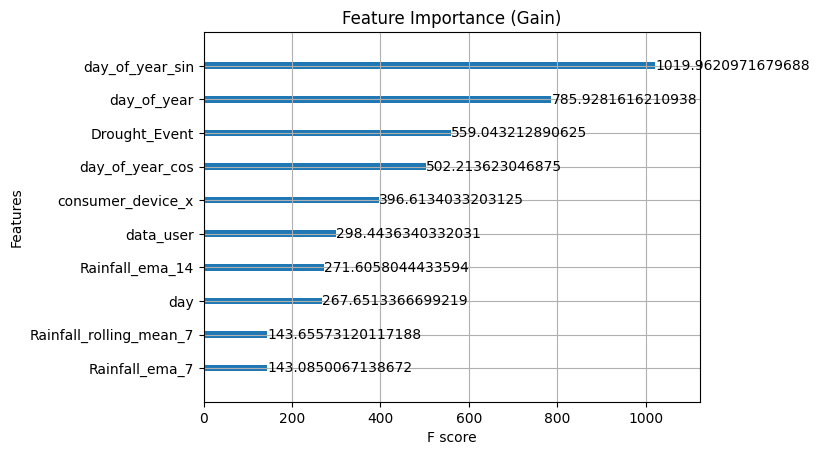

In [73]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot the feature importance using XGBoost's built-in plot_importance function
xgb.plot_importance(final_xgb, importance_type='gain', max_num_features=10)  # Adjust max_num_features as needed
plt.title('Feature Importance (Gain)')
plt.show()


In [ ]:
# -----------------------------
# PREPARE THE SUBMISSION FILE
# -----------------------------
# Assuming the submission format is the same as test_df with columns "ID" and "kwh".
# submission = test_merged.to_pandas().copy()
# submission["kwh"] = final_test_pred

# #submission['kwh'] = submission['kwh'].round(2) #ROUND

# # Round predictions to 2 decimal places and clip any negative values to 0
# submission['kwh'] = submission['kwh'].clip(lower=0).round(2)  # CLIP & ROUND


# submission_file = "/content/drive/MyDrive/ROUND-CLIP-IBM-SHCOC.csv"
# submission.to_csv(submission_file, index=False)
# print(f"Submission file saved as {submission_file}")

In [84]:
# Assuming the submission format is the same as test_df with columns "ID" and "kwh".
submission = test_merged.to_pandas().copy()
#submission["kwh"] = final_test_pred
#submission["kwh"] = test_pred_cat

#submission["kwh"] = test_pred_lgb

#submission["kwh"] = test_pred_xgb
submission["kwh"] = final_test_pred

# Round predictions to 2 decimal places and clip any negative values to 0
submission["kwh"] = submission["kwh"].clip(lower=0).round(2)  # CLIP-ROUND
# submission['kwh'] = submission['kwh'].round(2) #ROUND
# submission["kwh"] = submission["kwh"].clip(lower=0) # CLIP
#submission["kwh"] = submission["kwh"].clip(lower=0).round(4)  # CLIP-ROUND
# Keep only the required columns
submission = submission[["ID", "kwh"]]

# Save to CSV
submission_file = "tt-model-ensemble_final_test_pred-2-ROUNDED-CLIP-IBM-SHCOC-tt.csv"
submission.to_csv(submission_file, index=False)
print(f"Submission file saved as {submission_file}")


Submission file saved as tt-model-ensemble_final_test_pred-2-ROUNDED-CLIP-IBM-SHCOC-tt.csv
